## 0. Sampling 

In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [2]:
# undersampling the non frauds to have 5% frauds
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_2016.parquet")
df_nofraud = df_cct[df_cct["Is Fraud?"] == 0]
df_nofraud_sampled = df_nofraud.sample(int(0.95*(8412/0.05)), random_state = 0)

# recreating the dataframe
df_fraud = df_cct[df_cct["Is Fraud?"] == 1]
df_cct = pd.concat([df_nofraud_sampled, df_fraud], axis = 0).sort_index()

# retrieving the absolute amounts for score computation
df_amount = pd.read_parquet("/home/onyxia/work/df_all.parquet")

df_cct["abs_amount"] = list(df_amount.loc[df_cct.index]["Amount"].abs().values)

df_cct.reset_index(drop=True,inplace=True)

## I. OneHotEncoder

In [4]:
# For "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [5]:
# For "Card Brand":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Brand"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)


In [6]:
# For "Card Type":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Type"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [7]:
# For "label global":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["label_global"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [8]:
df_cct.rename(columns={0:"0", -1: "-1", 1:"1", 2:"2", 3: "3", 4:"4", 5:"5", 6:"6"}, inplace=True)

In [9]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?', 'pos_amount', 'abs_amount', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'Amex', 'Discover',
       'Mastercard', 'Visa', 'Credit', 'Debit', 'Debit (Prepaid)', '-1', '0',
       '1', '2', '3', '4', '5', '6'],
      dtype='object')

## II. Datasets (training, test)

In [10]:
# selecting features
# dropped card, nb_weekly_declines, day_of_week, nb_daily_declines, credit, debit, amex,  discover,
# mastercard, visa
features = ['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',"Is Fraud?",
        "-1","0","1","2","3","4","5","6"]

df_selec = df_cct[features] # 21 features + clusters

X = df_selec[['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',"-1","0","1","2","3","4","5","6"]]
       
y = df_selec["Is Fraud?"]

In [11]:
# Splitting the data into train and test data  (70:30)

# Create a STRATIFIED train-test (Hence, passing the argument 'stratify= y')
# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle = True, random_state = 0, stratify = y)

In [12]:
# Checking class distribution in stratified train-test split
from collections import Counter

print("In y dataset:", Counter(y))
print("\nIn y_train set:", Counter(y_train))
print("\nIn y_test set:", Counter(y_test))

In y dataset: Counter({0: 159828, 1: 8412})

In y_train set: Counter({0: 111879, 1: 5888})

In y_test set: Counter({0: 47949, 1: 2524})


In [29]:
# Useless 
#df_train = df_selec.loc[X_train.index]

## III. Functions for final results

In [30]:
# Create a pandas dataframe to store model results
results_df = pd.DataFrame(columns=['Data Handling Technique','Model', 'Precision','Recall','F1 score', "Our Score"])

In [14]:
# building our own score
def our_score(clf, X, y):

    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel() # retrieving tn, fp, fn, tp
    
    fp_rows = [] 

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 0:
            fp_rows.append(y.index[i]) 

    fn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 1:
            fn_rows.append(y.index[i])

    tp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 1:
            tp_rows.append(y.index[i])

    tn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 0:
            tn_rows.append(y.index[i])

    df_fp = df_cct.loc[fp_rows] 
    fp_new = df_fp.loc[df_fp["abs_amount"]>=15].index # defining fp rows which amount above 15$

    df_tp = df_cct.loc[tp_rows]
    tp_new = df_tp.loc[df_tp["abs_amount"]>=15].index

    df_fn = df_cct.loc[fn_rows]
    fn_new = df_fn.loc[df_fn["abs_amount"]>=15].index

    our_score = -15*(len(fp_new) + len(tp_new)) + df_cct.loc[tp_new]["abs_amount"].sum() - df_cct.loc[fn_rows]["abs_amount"].sum() - df_cct.loc[tp_rows]["abs_amount"].sum()

    our_score_norm = (our_score + df_cct.loc[fn_rows]["abs_amount"].sum() + df_cct.loc[tp_rows]["abs_amount"].sum())/(df_cct.loc[tp_new]["abs_amount"].sum()+df_cct.loc[fn_new]["abs_amount"].sum() - 15*(len(tp_new)+len(fn_new)))

    return our_score_norm

In [15]:
# calculate retrieved or lost money
def retrieved_money(clf, X, y):

    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    fp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 0:
            fp_rows.append(y.index[i])

    fn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 1:
            fn_rows.append(y.index[i])

    tp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 1:
            tp_rows.append(y.index[i])

    tn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 0:
            tn_rows.append(y.index[i])

    df_fp = df_cct.loc[fp_rows]
    fp_new = df_fp.loc[df_fp["abs_amount"]>=15].index

    df_tp = df_cct.loc[tp_rows]
    tp_new = df_tp.loc[df_tp["abs_amount"]>=15].index

    df_fn = df_cct.loc[fn_rows]
    fn_new = df_fn.loc[df_fn["abs_amount"]>=15].index

    initial_loss = - df_cct.loc[fn_rows]["abs_amount"].sum() - df_cct.loc[tp_rows]["abs_amount"].sum()

    retrieved_money = -15*(len(fp_new) + len(tp_new)) + df_cct.loc[tp_new]["abs_amount"].sum() 

    max_retrieved_money = df_cct.loc[tp_new]["abs_amount"].sum()+df_cct.loc[fn_new]["abs_amount"].sum() - 15*(len(tp_new)+len(fn_new))

    return initial_loss, retrieved_money, max_retrieved_money

In [16]:
# plot confusion matrix
def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=['Non-Fraudulent','Fraudulent']
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize= 10)
    plt.xlabel('Predicted label', fontsize=10)

In [17]:
# Define a function to plot ROC_AUC curve
def plot_roc_auc_curve(fpr, tpr, roc_auc):
    print(f"ROC for test dataset {round(roc_auc*100,3)}%")  
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.plot(fpr,tpr,'b',label="Test ROC_AUC="+str(round(roc_auc,3)))
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.legend(loc='lower right')
    plt.show()

In [13]:
# 10 fold CV
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=False)
kf.split(X_train, y_train)
for train_index, test_index in kf.split(X_train, y_train):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape , str("\n"))
    print("TRAIN:", train_index, "\n\nTEST:", test_index , str("\n"))

TRAIN: (105990,) TEST: (11777,) 

TRAIN: [ 11760  11761  11762 ... 117764 117765 117766] 

TEST: [    0     1     2 ... 12048 12076 12077] 

TRAIN: (105990,) TEST: (11777,) 

TRAIN: [     0      1      2 ... 117764 117765 117766] 

TEST: [11760 11761 11762 ... 23712 23742 23768] 

TRAIN: (105990,) TEST: (11777,) 

TRAIN: [     0      1      2 ... 117764 117765 117766] 

TEST: [23542 23543 23544 ... 35427 35453 35509] 

TRAIN: (105990,) TEST: (11777,) 

TRAIN: [     0      1      2 ... 117764 117765 117766] 

TEST: [35322 35323 35324 ... 47638 47662 47663] 

TRAIN: (105990,) TEST: (11777,) 

TRAIN: [     0      1      2 ... 117764 117765 117766] 

TEST: [47065 47066 47067 ... 60731 60732 60756] 

TRAIN: (105990,) TEST: (11777,) 

TRAIN: [     0      1      2 ... 117764 117765 117766] 

TEST: [58808 58809 58811 ... 71737 71741 71747] 

TRAIN: (105990,) TEST: (11777,) 

TRAIN: [     0      1      2 ... 117764 117765 117766] 

TEST: [70593 70594 70595 ... 82687 82708 82751] 

TRAIN: (10599

## IV. GridSearch

In [25]:
# Hyperparameters 
C_param = [1,10,100, 1000, 10000]
weights_param = [{0:1,1:i} for i in [1, 10, 14, 15, 16, 20, 50, 100, 150, 1000]]
solver_param = ['liblinear', 'newton-cholesky']

param = {'solver' :solver_param, 'class_weight':weights_param, 'C':C_param}

# GridSearch
model = LogisticRegression(random_state = 0)
CV_model = GridSearchCV(estimator=model, cv = kf, n_jobs = -1, param_grid = param, scoring = our_score,verbose=10)
CV_model.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10; 1/100] START C=1, class_weight={0: 1, 1: 1}, solver=liblinear.........
[CV 2/10; 1/100] START C=1, class_weight={0: 1, 1: 1}, solver=liblinear.........
[CV 3/10; 1/100] START C=1, class_weight={0: 1, 1: 1}, solver=liblinear.........
[CV 4/10; 1/100] START C=1, class_weight={0: 1, 1: 1}, solver=liblinear.........
[CV 5/10; 1/100] START C=1, class_weight={0: 1, 1: 1}, solver=liblinear.........
[CV 6/10; 1/100] START C=1, class_weight={0: 1, 1: 1}, solver=liblinear.........
[CV 7/10; 1/100] START C=1, class_weight={0: 1, 1: 1}, solver=liblinear.........
[CV 8/10; 1/100] START C=1, class_weight={0: 1, 1: 1}, solver=liblinear.........
[CV 9/10; 1/100] START C=1, class_weight={0: 1, 1: 1}, solver=liblinear.........
[CV 10/10; 1/100] START C=1, class_weight={0: 1, 1: 1}, solver=liblinear........
[CV 1/10; 2/100] START C=1, class_weight={0: 1, 1: 1}, solver=newton-cholesky...
[CV 2/10; 2/100] START C=1, class_weight={0:

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 4/10; 3/100] START C=1, class_weight={0: 1, 1: 10}, solver=liblinear........
[CV 4/10; 2/100] END C=1, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.215 total time=   0.5s
[CV 5/10; 3/100] START C=1, class_weight={0: 1, 1: 10}, solver=liblinear........
[CV 6/10; 3/100] START C=1, class_weight={0: 1, 1: 10}, solver=liblinear........
[CV 7/10; 3/100] START C=1, class_weight={0: 1, 1: 10}, solver=liblinear........


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 8/10; 3/100] START C=1, class_weight={0: 1, 1: 10}, solver=liblinear........
[CV 9/10; 3/100] START C=1, class_weight={0: 1, 1: 10}, solver=liblinear........
[CV 10/10; 3/100] START C=1, class_weight={0: 1, 1: 10}, solver=liblinear.......
[CV 1/10; 4/100] START C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky..
[CV 2/10; 4/100] START C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky..
[CV 3/10; 4/100] START C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky..
[CV 4/10; 4/100] START C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky..
[CV 5/10; 4/100] START C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky..
[CV 6/10; 4/100] START C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky..
[CV 7/10; 4/100] START C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky..
[CV 8/10; 4/100] START C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky..
[CV 9/10; 4/100] START C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky..
[CV 10/10; 4/100] START C=1,

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 1/10; 5/100] START C=1, class_weight={0: 1, 1: 14}, solver=liblinear........


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 4/10; 4/100] END C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.565 total time=   0.7s
[CV 2/10; 5/100] START C=1, class_weight={0: 1, 1: 14}, solver=liblinear........


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 1/10; 2/100] END C=1, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.281 total time=   2.2s
[CV 5/10; 2/100] END C=1, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.325 total time=   2.0s
[CV 3/10; 5/100] START C=1, class_weight={0: 1, 1: 14}, solver=liblinear........
[CV 4/10; 5/100] START C=1, class_weight={0: 1, 1: 14}, solver=liblinear........
[CV 7/10; 2/100] END C=1, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.257 total time=   2.1s
[CV 3/10; 2/100] END C=1, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.248 total time=   2.3s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 8/10; 2/100] END C=1, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.205 total time=   2.1s
[CV 5/10; 5/100] START C=1, class_weight={0: 1, 1: 14}, solver=liblinear........
[CV 6/10; 5/100] START C=1, class_weight={0: 1, 1: 14}, solver=liblinear........
[CV 7/10; 5/100] START C=1, class_weight={0: 1, 1: 14}, solver=liblinear........
[CV 3/10; 1/100] END C=1, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.248 total time=   2.8s
[CV 2/10; 2/100] END C=1, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.286 total time=   2.5s
[CV 8/10; 5/100] START C=1, class_weight={0: 1, 1: 14}, solver=liblinear........
[CV 9/10; 5/100] START C=1, class_weight={0: 1, 1: 14}, solver=liblinear........
[CV 9/10; 2/100] END C=1, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.207 total time=   2.4s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 6/10; 2/100] END C=1, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.250 total time=   2.6s
[CV 10/10; 5/100] START C=1, class_weight={0: 1, 1: 14}, solver=liblinear.......
[CV 1/10; 6/100] START C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky..
[CV 5/10; 1/100] END C=1, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.313 total time=   3.2s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 2/10; 6/100] START C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky..
[CV 10/10; 2/100] END C=1, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.302 total time=   2.7s
[CV 3/10; 6/100] START C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 3/10; 4/100] END C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.566 total time=   2.4s
[CV 5/10; 4/100] END C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.564 total time=   2.4s
[CV 4/10; 6/100] START C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky..
[CV 2/10; 4/100] END C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.525 total time=   2.5s
[CV 5/10; 6/100] START C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky..
[CV 6/10; 6/100] START C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 7/10; 4/100] END C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.559 total time=   2.6s
[CV 7/10; 6/100] START C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 6/10; 4/100] END C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.546 total time=   2.8s
[CV 8/10; 6/100] START C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky..
[CV 4/10; 6/100] END C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.497 total time=   0.6s
[CV 9/10; 6/100] START C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 10/10; 4/100] END C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.505 total time=   2.9s
[CV 10/10; 6/100] START C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky.
[CV 1/10; 4/100] END C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.487 total time=   3.5s
[CV 9/10; 4/100] END C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.533 total time=   3.1s
[CV 1/10; 7/100] START C=1, class_weight={0: 1, 1: 15}, solver=liblinear........
[CV 2/10; 7/100] START C=1, class_weight={0: 1, 1: 15}, solver=liblinear........


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 2/10; 1/100] END C=1, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.286 total time=   5.1s
[CV 6/10; 1/100] END C=1, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.249 total time=   4.9s
[CV 3/10; 7/100] START C=1, class_weight={0: 1, 1: 15}, solver=liblinear........
[CV 3/10; 3/100] END C=1, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.562 total time=   4.3s
[CV 8/10; 4/100] END C=1, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.517 total time=   3.5s
[CV 4/10; 7/100] START C=1, class_weight={0: 1, 1: 15}, solver=liblinear........
[CV 5/10; 7/100] START C=1, class_weight={0: 1, 1: 15}, solver=liblinear........
[CV 6/10; 7/100] START C=1, class_weight={0: 1, 1: 15}, solver=liblinear........
[CV 9/10; 1/100] END C=1, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.212 total time=   5.0s
[CV 7/10; 7/100] START C=1, class_weight={0: 1, 1: 15}, solver=liblinear........
[CV 1/10; 1/100] END C=1, class_weight={0: 1, 1: 1}, solver=liblinear;, 

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 7/10; 1/100] END C=1, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.244 total time=   5.3s
[CV 10/10; 7/100] START C=1, class_weight={0: 1, 1: 15}, solver=liblinear.......
[CV 4/10; 1/100] END C=1, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.215 total time=   5.8s
[CV 1/10; 8/100] START C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 2/10; 6/100] END C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.468 total time=   2.7s
[CV 2/10; 8/100] START C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 5/10; 6/100] END C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.475 total time=   2.4s
[CV 3/10; 8/100] START C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 7/10; 6/100] END C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.495 total time=   2.4s
[CV 4/10; 8/100] START C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky..
[CV 3/10; 6/100] END C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.474 total time=   3.2s
[CV 3/10; 5/100] END C=1, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.479 total time=   4.1s
[CV 6/10; 6/100] END C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.448 total time=   2.7s
[CV 5/10; 8/100] START C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky..
[CV 6/10; 8/100] START C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 7/10; 8/100] START C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky..
[CV 8/10; 6/100] END C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.406 total time=   2.4s
[CV 8/10; 8/100] START C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky..
[CV 10/10; 3/100] END C=1, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.499 total time=   5.7s
[CV 9/10; 8/100] START C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 9/10; 5/100] END C=1, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.443 total time=   4.2s
[CV 2/10; 5/100] END C=1, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.474 total time=   5.1s
[CV 10/10; 8/100] START C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky.
[CV 1/10; 3/100] END C=1, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.487 total time=   6.6s
[CV 4/10; 8/100] END C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.476 total time=   0.7s
[CV 1/10; 9/100] START C=1, class_weight={0: 1, 1: 16}, solver=liblinear........
[CV 8/10; 1/100] END C=1, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.212 total time=   7.2s
[CV 2/10; 9/100] START C=1, class_weight={0: 1, 1: 16}, solver=liblinear........
[CV 3/10; 9/100] START C=1, class_weight={0: 1, 1: 16}, solver=liblinear........
[CV 4/10; 9/100] START C=1, class_weight={0: 1, 1: 16}, solver=liblinear........


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 7/10; 5/100] END C=1, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.493 total time=   5.0s
[CV 10/10; 5/100] END C=1, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.434 total time=   4.7s
[CV 9/10; 6/100] END C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.444 total time=   3.3s
[CV 5/10; 9/100] START C=1, class_weight={0: 1, 1: 16}, solver=liblinear........
[CV 6/10; 9/100] START C=1, class_weight={0: 1, 1: 16}, solver=liblinear........
[CV 10/10; 6/100] END C=1, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.439 total time=   3.2s
[CV 7/10; 9/100] START C=1, class_weight={0: 1, 1: 16}, solver=liblinear........
[CV 8/10; 9/100] START C=1, class_weight={0: 1, 1: 16}, solver=liblinear........
[CV 5/10; 3/100] END C=1, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.563 total time=   7.2s
[CV 9/10; 9/100] START C=1, class_weight={0: 1, 1: 16}, solver=liblinear........


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 6/10; 5/100] END C=1, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.450 total time=   5.6s
[CV 1/10; 8/100] END C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.376 total time=   2.5s
[CV 10/10; 9/100] START C=1, class_weight={0: 1, 1: 16}, solver=liblinear.......
[CV 6/10; 3/100] END C=1, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.546 total time=   7.4s
[CV 1/10; 10/100] START C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky.
[CV 2/10; 10/100] START C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky.
[CV 10/10; 1/100] END C=1, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.305 total time=   8.4s
[CV 3/10; 10/100] START C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky.
[CV 2/10; 8/100] END C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.449 total time=   2.7s
[CV 4/10; 10/100] START C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky.


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 3/10; 7/100] END C=1, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.453 total time=   3.8s
[CV 3/10; 8/100] END C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.452 total time=   2.6s
[CV 5/10; 10/100] START C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky.
[CV 6/10; 8/100] END C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.425 total time=   2.3s
[CV 6/10; 10/100] START C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky.
[CV 8/10; 3/100] END C=1, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.517 total time=   8.0s
[CV 2/10; 7/100] END C=1, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.450 total time=   4.2s
[CV 7/10; 10/100] START C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky.
[CV 5/10; 5/100] END C=1, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.471 total time=   6.4s
[CV 8/10; 10/100] START C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky.


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 9/10; 10/100] START C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky.
[CV 10/10; 10/100] START C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 1/10; 7/100] END C=1, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.365 total time=   4.5s
[CV 4/10; 10/100] END C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.453 total time=   0.5s
[CV 10/10; 7/100] END C=1, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.410 total time=   3.8s
[CV 1/10; 11/100] START C=1, class_weight={0: 1, 1: 20}, solver=liblinear.......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 2/10; 11/100] START C=1, class_weight={0: 1, 1: 20}, solver=liblinear.......
[CV 9/10; 3/100] END C=1, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.538 total time=   8.3s
[CV 3/10; 11/100] START C=1, class_weight={0: 1, 1: 20}, solver=liblinear.......
[CV 8/10; 8/100] END C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.381 total time=   2.6s
[CV 4/10; 11/100] START C=1, class_weight={0: 1, 1: 20}, solver=liblinear.......
[CV 5/10; 11/100] START C=1, class_weight={0: 1, 1: 20}, solver=liblinear.......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 5/10; 8/100] END C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.453 total time=   3.2s
[CV 9/10; 8/100] END C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.413 total time=   3.0s
[CV 6/10; 11/100] START C=1, class_weight={0: 1, 1: 20}, solver=liblinear.......
[CV 7/10; 11/100] START C=1, class_weight={0: 1, 1: 20}, solver=liblinear.......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 7/10; 8/100] END C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.468 total time=   3.3s
[CV 7/10; 7/100] END C=1, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.469 total time=   4.8s
[CV 8/10; 11/100] START C=1, class_weight={0: 1, 1: 20}, solver=liblinear.......
[CV 9/10; 11/100] START C=1, class_weight={0: 1, 1: 20}, solver=liblinear.......
[CV 7/10; 3/100] END C=1, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.543 total time=   9.5s
[CV 10/10; 11/100] START C=1, class_weight={0: 1, 1: 20}, solver=liblinear......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 10/10; 8/100] END C=1, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.408 total time=   3.5s
[CV 6/10; 7/100] END C=1, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.424 total time=   5.6s
[CV 1/10; 12/100] START C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky.
[CV 2/10; 12/100] START C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky.


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 2/10; 3/100] END C=1, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.535 total time=  10.3s
[CV 3/10; 12/100] START C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky.
[CV 2/10; 9/100] END C=1, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.426 total time=   3.8s
[CV 4/10; 12/100] START C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky.
[CV 9/10; 7/100] END C=1, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.412 total time=   5.8s
[CV 5/10; 12/100] START C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky.
[CV 1/10; 5/100] END C=1, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.388 total time=   9.6s
[CV 6/10; 12/100] START C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky.
[CV 8/10; 5/100] END C=1, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.418 total time=   8.6s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 7/10; 12/100] START C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky.
[CV 7/10; 10/100] END C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.451 total time=   2.5s
[CV 9/10; 10/100] END C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.382 total time=   2.4s
[CV 8/10; 12/100] START C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky.
[CV 4/10; 7/100] END C=1, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.476 total time=   6.5s
[CV 8/10; 10/100] END C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.360 total time=   2.6s
[CV 9/10; 12/100] START C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky.
[CV 4/10; 5/100] END C=1, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.497 total time=   9.1s
[CV 4/10; 12/100] END C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.336 total time=   0.5s
[CV 1/10; 9/100] END C=1, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.342 total time=   4.4s
[

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 4/10; 13/100] START C=1, class_weight={0: 1, 1: 50}, solver=liblinear.......
[CV 5/10; 9/100] END C=1, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.427 total time=   4.2s
[CV 5/10; 13/100] START C=1, class_weight={0: 1, 1: 50}, solver=liblinear.......
[CV 6/10; 13/100] START C=1, class_weight={0: 1, 1: 50}, solver=liblinear.......
[CV 8/10; 9/100] END C=1, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.361 total time=   4.1s
[CV 6/10; 10/100] END C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.398 total time=   3.1s
[CV 7/10; 13/100] START C=1, class_weight={0: 1, 1: 50}, solver=liblinear.......
[CV 8/10; 13/100] START C=1, class_weight={0: 1, 1: 50}, solver=liblinear.......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 9/10; 13/100] START C=1, class_weight={0: 1, 1: 50}, solver=liblinear.......
[CV 10/10; 13/100] START C=1, class_weight={0: 1, 1: 50}, solver=liblinear......
[CV 8/10; 7/100] END C=1, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.386 total time=   6.9s
[CV 5/10; 10/100] END C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.432 total time=   3.4s
[CV 1/10; 14/100] START C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky.
[CV 4/10; 9/100] END C=1, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.453 total time=   4.8s
[CV 10/10; 10/100] END C=1, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.393 total time=   3.1s
[CV 5/10; 7/100] END C=1, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.452 total time=   7.2s
[CV 2/10; 14/100] START C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky.
[CV 3/10; 14/100] START C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky.
[CV 4/10; 14/100] START C=1, class_weight={0: 1, 1: 50}, sol

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 3/10; 9/100] END C=1, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.425 total time=   5.3s
[CV 4/10; 3/100] END C=1, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.565 total time=  11.9s
[CV 6/10; 14/100] START C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky.
[CV 10/10; 9/100] END C=1, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.391 total time=   4.5s
[CV 7/10; 14/100] START C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky.
[CV 8/10; 14/100] START C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky.


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 4/10; 14/100] END C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.228 total time=   0.7s
[CV 9/10; 14/100] START C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky.
[CV 2/10; 12/100] END C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.329 total time=   2.4s
[CV 10/10; 14/100] START C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 6/10; 9/100] END C=1, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.402 total time=   5.6s
[CV 1/10; 15/100] START C=1, class_weight={0: 1, 1: 100}, solver=liblinear......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 3/10; 12/100] END C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.336 total time=   2.5s
[CV 5/10; 12/100] END C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.343 total time=   2.4s
[CV 2/10; 15/100] START C=1, class_weight={0: 1, 1: 100}, solver=liblinear......
[CV 1/10; 12/100] END C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.258 total time=   2.9s
[CV 3/10; 15/100] START C=1, class_weight={0: 1, 1: 100}, solver=liblinear......
[CV 4/10; 15/100] START C=1, class_weight={0: 1, 1: 100}, solver=liblinear......
[CV 7/10; 12/100] END C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.345 total time=   2.3s
[CV 5/10; 11/100] END C=1, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.340 total time=   4.3s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 7/10; 9/100] END C=1, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.447 total time=   6.0s
[CV 5/10; 15/100] START C=1, class_weight={0: 1, 1: 100}, solver=liblinear......
[CV 6/10; 15/100] START C=1, class_weight={0: 1, 1: 100}, solver=liblinear......
[CV 6/10; 12/100] END C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.319 total time=   2.6s
[CV 7/10; 15/100] START C=1, class_weight={0: 1, 1: 100}, solver=liblinear......
[CV 8/10; 15/100] START C=1, class_weight={0: 1, 1: 100}, solver=liblinear......
[CV 8/10; 12/100] END C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.273 total time=   2.5s
[CV 9/10; 15/100] START C=1, class_weight={0: 1, 1: 100}, solver=liblinear......
[CV 3/10; 11/100] END C=1, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.334 total time=   4.8s
[CV 10/10; 15/100] START C=1, class_weight={0: 1, 1: 100}, solver=liblinear.....
[CV 4/10; 11/100] END C=1, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.3

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 7/10; 11/100] END C=1, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.342 total time=   4.6s
[CV 2/10; 16/100] START C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 9/10; 12/100] END C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.285 total time=   2.9s
[CV 3/10; 16/100] START C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 6/10; 11/100] END C=1, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.320 total time=   4.7s
[CV 4/10; 16/100] START C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 5/10; 16/100] START C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 8/10; 11/100] END C=1, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.278 total time=   4.7s
[CV 1/10; 14/100] END C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.405 total time=   2.6s
[CV 6/10; 16/100] START C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 10/10; 12/100] END C=1, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.293 total time=   3.2s
[CV 7/10; 16/100] START C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 8/10; 16/100] START C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 3/10; 14/100] END C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.241 total time=   2.8s
[CV 9/10; 16/100] START C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 4/10; 16/100] END C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.591 total time=   0.8s
[CV 10/10; 16/100] START C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 7/10; 14/100] END C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.281 total time=   2.6s
[CV 9/10; 11/100] END C=1, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.280 total time=   5.4s
[CV 1/10; 17/100] START C=1, class_weight={0: 1, 1: 150}, solver=liblinear......
[CV 5/10; 14/100] END C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.310 total time=   3.0s
[CV 2/10; 17/100] START C=1, class_weight={0: 1, 1: 150}, solver=liblinear......
[CV 3/10; 17/100] START C=1, class_weight={0: 1, 1: 150}, solver=liblinear......
[CV 9/10; 14/100] END C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.337 total time=   2.6s
[CV 1/10; 11/100] END C=1, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.252 total time=   6.5s
[CV 4/10; 17/100

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 2/10; 14/100] END C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.223 total time=   3.5s
[CV 2/10; 11/100] END C=1, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.328 total time=   6.5s
[CV 5/10; 17/100] START C=1, class_weight={0: 1, 1: 150}, solver=liblinear......
[CV 6/10; 17/100] START C=1, class_weight={0: 1, 1: 150}, solver=liblinear......
[CV 10/10; 14/100] END C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.297 total time=   2.7s
[CV 7/10; 17/100] START C=1, class_weight={0: 1, 1: 150}, solver=liblinear......
[CV 6/10; 14/100] END C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.243 total time=   3.2s
[CV 8/10; 17/100] START C=1, class_weight={0: 1, 1: 150}, solver=liblinear......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 9/10; 17/100] START C=1, class_weight={0: 1, 1: 150}, solver=liblinear......
[CV 8/10; 14/100] END C=1, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.358 total time=   3.4s
[CV 10/10; 17/100] START C=1, class_weight={0: 1, 1: 150}, solver=liblinear.....
[CV 10/10; 11/100] END C=1, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.291 total time=   6.2s
[CV 1/10; 18/100] START C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 3/10; 15/100] END C=1, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.577 total time=   3.1s
[CV 2/10; 18/100] START C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 2/10; 16/100] END C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.589 total time=   2.6s
[CV 3/10; 18/100] START C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 7/10; 16/100] END C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.687 total time=   2.4s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 4/10; 18/100] START C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 2/10; 13/100] END C=1, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.220 total time=   5.6s
[CV 9/10; 16/100] END C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.712 total time=   2.2s
[CV 5/10; 18/100] START C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 6/10; 18/100] START C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 5/10; 15/100] END C=1, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.684 total time=   3.8s
[CV 1/10; 16/100] END C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.813 total time=   3.4s
[CV 7/10; 18/100] START C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 8/10; 18/100] START C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 6/10; 16/100] END C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.585 total time=   2.9s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 9/10; 18/100] START C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 3/10; 16/100] END C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.611 total time=   3.4s
[CV 4/10; 18/100] END C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.721 total time=   0.6s
[CV 10/10; 18/100] START C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 1/10; 15/100] END C=1, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.801 total time=   4.6s
[CV 9/10; 15/100] END C=1, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.685 total time=   3.9s
[CV 1/10; 19/100] START C=1, class_weight={0: 1, 1: 1000}, solver=liblinear.....
[CV 2/10; 19/100] START C=1, class_weight={0: 1, 1: 1000}, solver=liblinear.....
[CV 8/10; 13/100] END C=1, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.341 total time=   6.1s
[CV 3/10; 19/100] START C=1, class_weight={0: 1, 1: 1000}, solver=liblinear.....
[CV 4/10; 19/100] START C=1, class_weight={0: 1,

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 10/10; 15/100] END C=1, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.677 total time=   4.1s
[CV 5/10; 13/100] END C=1, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.308 total time=   6.4s
[CV 5/10; 19/100] START C=1, class_weight={0: 1, 1: 1000}, solver=liblinear.....
[CV 6/10; 19/100] START C=1, class_weight={0: 1, 1: 1000}, solver=liblinear.....
[CV 10/10; 13/100] END C=1, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.300 total time=   6.2s
[CV 5/10; 16/100] END C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.703 total time=   3.8s
[CV 7/10; 19/100] START C=1, class_weight={0: 1, 1: 1000}, solver=liblinear.....
[CV 6/10; 15/100] END C=1, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.562 total time=   4.6s
[CV 8/10; 19/100] START C=1, class_weight={0: 1, 1: 1000}, solver=liblinear.....
[CV 9/10; 19/100] START C=1, class_weight={0: 1, 1: 1000}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 8/10; 16/100] END C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.732 total time=   3.8s
[CV 9/10; 13/100] END C=1, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.328 total time=   6.6s
[CV 10/10; 19/100] START C=1, class_weight={0: 1, 1: 1000}, solver=liblinear....
[CV 1/10; 20/100] START C=1, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 4/10; 15/100] END C=1, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.591 total time=   5.1s
[CV 10/10; 16/100] END C=1, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.710 total time=   3.5s
[CV 2/10; 20/100] START C=1, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 8/10; 17/100] END C=1, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.871 total time=   2.9s
[CV 3/10; 17/100] END C=1, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.702 total time=   3.4s
[CV 4/10; 17/100] END C=1, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.721 total time=  

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 10/10; 20/100] START C=1, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 1/10; 17/100] END C=1, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.933 total time=   4.0s
[CV 1/10; 21/100] START C=10, class_weight={0: 1, 1: 1}, solver=liblinear.......
[CV 1/10; 18/100] END C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.966 total time=   2.8s
[CV 2/10; 21/100] START C=10, class_weight={0: 1, 1: 1}, solver=liblinear.......
[CV 4/10; 20/100] END C=1, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.868 total time=   0.7s
[CV 3/10; 21/100] START C=10, class_weight={0: 1, 1: 1}, solver=liblinear.......
[CV 2/10; 18/100] END C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.725 total time=   2.9s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 4/10; 21/100] START C=10, class_weight={0: 1, 1: 1}, solver=liblinear.......
[CV 3/10; 18/100] END C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.736 total time=   2.7s
[CV 5/10; 21/100] START C=10, class_weight={0: 1, 1: 1}, solver=liblinear.......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 8/10; 15/100] END C=1, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.735 total time=   6.0s
[CV 6/10; 18/100] END C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.699 total time=   2.6s
[CV 6/10; 21/100] START C=10, class_weight={0: 1, 1: 1}, solver=liblinear.......
[CV 7/10; 13/100] END C=1, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.272 total time=   8.1s
[CV 7/10; 21/100] START C=10, class_weight={0: 1, 1: 1}, solver=liblinear.......
[CV 8/10; 21/100] START C=10, class_weight={0: 1, 1: 1}, solver=liblinear.......
[CV 7/10; 18/100] END C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.827 total time=   2.6s
[CV 9/10; 21/100] START C=10, class_weight={0: 1, 1: 1}, solver=liblinear.......
[CV 5/10; 18/100] END C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.834 total time=   2.9s
[CV 7/10; 17/100] END C=1, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.794 total time=   4.5s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 2/10; 15/100] END C=1, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.571 total time=   6.8s
[CV 10/10; 21/100] START C=10, class_weight={0: 1, 1: 1}, solver=liblinear......
[CV 1/10; 22/100] START C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky.
[CV 2/10; 22/100] START C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky.
[CV 1/10; 19/100] END C=1, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-1.090 total time=   2.6s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 10/10; 18/100] END C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.827 total time=   2.7s
[CV 3/10; 22/100] START C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky.
[CV 10/10; 17/100] END C=1, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.801 total time=   4.4s
[CV 4/10; 22/100] START C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky.
[CV 3/10; 13/100] END C=1, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.225 total time=   9.0s
[CV 9/10; 18/100] END C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.855 total time=   3.0s
[CV 5/10; 22/100] START C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky.


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 6/10; 22/100] START C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky.
[CV 7/10; 22/100] START C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky.
[CV 8/10; 19/100] END C=1, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-1.040 total time=   2.4s
[CV 1/10; 13/100] END C=1, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.399 total time=   9.3s
[CV 8/10; 22/100] START C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky.
[CV 9/10; 22/100] START C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky.
[CV 2/10; 17/100] END C=1, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.704 total time=   5.6s
[CV 10/10; 22/100] START C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 2/10; 19/100] END C=1, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.848 total time=   3.1s
[CV 1/10; 23/100] START C=10, class_weight={0: 1, 1: 10}, solver=liblinear......
[CV 9/10; 19/100] END C=1, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 7/10; 15/100] END C=1, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.661 total time=   7.7s
[CV 5/10; 20/100] END C=1, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.973 total time=   2.6s
[CV 8/10; 18/100] END C=1, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.898 total time=   4.0s
[CV 5/10; 23/100] START C=10, class_weight={0: 1, 1: 10}, solver=liblinear......
[CV 10/10; 20/100] END C=1, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.951 total time=   2.4s
[CV 6/10; 23/100] START C=10, class_weight={0: 1, 1: 10}, solver=liblinear......
[CV 2/10; 20/100] END C=1, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.849 total time=   2.9s
[CV 7/10; 23/100] START C=10, class_weight={0: 1, 1: 10}, solver=liblinear......
[CV 4/10; 19/100] END C=1, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.868 total time=   3.7s
[CV 8/10; 23/100] START C=10, class_weight={0: 1, 1: 10}, solver=liblinear......
[CV 9

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 6/10; 20/100] END C=1, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.833 total time=   2.9s
[CV 1/10; 24/100] START C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 2/10; 24/100] START C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 3/10; 24/100] START C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 7/10; 19/100] END C=1, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.938 total time=   3.8s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 4/10; 24/100] START C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 9/10; 20/100] END C=1, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.971 total time=   3.1s
[CV 7/10; 20/100] END C=1, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.942 total time=   3.2s
[CV 5/10; 24/100] START C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 6/10; 24/100] START C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 8/10; 20/100] END C=1, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-1.043 total time=   3.3s
[CV 3/10; 19/100] END C=1, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.836 total time=   4.4s
[CV 7/10; 24/100] START C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 3/10; 21/100] END C=10, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.248 total time=   2.9s
[CV 3/10; 20/100] END C=1, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.839 total time=   3.7s
[CV 8/10; 24/100] START C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 9/10; 24/100] START C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 5/10; 17/100] END C=1, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.813 total time=   6.9s
[CV 10/10; 24/100] START C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 4/10; 24/100] END C=10, class_weight={0: 1

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 2/10; 22/100] END C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.286 total time=   2.4s
[CV 3/10; 25/100] START C=10, class_weight={0: 1, 1: 14}, solver=liblinear......
[CV 3/10; 22/100] END C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.248 total time=   2.5s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 4/10; 25/100] START C=10, class_weight={0: 1, 1: 14}, solver=liblinear......
[CV 6/10; 19/100] END C=1, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.830 total time=   4.9s
[CV 1/10; 22/100] END C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.292 total time=   2.9s
[CV 8/10; 22/100] END C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.205 total time=   2.4s
[CV 5/10; 25/100] START C=10, class_weight={0: 1, 1: 14}, solver=liblinear......
[CV 6/10; 25/100] START C=10, class_weight={0: 1, 1: 14}, solver=liblinear......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 10/10; 22/100] END C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.301 total time=   2.3s
[CV 7/10; 25/100] START C=10, class_weight={0: 1, 1: 14}, solver=liblinear......
[CV 1/10; 21/100] END C=10, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.292 total time=   4.0s
[CV 8/10; 25/100] START C=10, class_weight={0: 1, 1: 14}, solver=liblinear......
[CV 9/10; 25/100] START C=10, class_weight={0: 1, 1: 14}, solver=liblinear......
[CV 6/10; 22/100] END C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.249 total time=   2.7s
[CV 10/10; 25/100] START C=10, class_weight={0: 1, 1: 14}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/10; 22/100] END C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.314 total time=   2.9s
[CV 1/10; 26/100] START C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 7/10; 22/100] END C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.244 total time=   3.1s
[CV 9/10; 22/100] END C=10, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.207 total time=   2.9s
[CV 2/10; 26/100] START C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 3/10; 26/100] START C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 3/10; 24/100] END C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.565 total time=   2.3s
[CV 4/10; 26/100] START C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/10; 21/100] END C=10, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.313 total time=   4.9s
[CV 5/10; 24/100] END C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.564 total time=   2.4s
[CV 5/10; 26/100] START C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 6/10; 26/100] START C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 4/10; 26/100] END C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.497 total time=   0.5s
[CV 7/10; 21/100] END C=10, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.244 total time=   5.0s
[CV 7/10; 26/100] START C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 8/10; 26/100] START C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 8/10; 24/100] END C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.518 total time=   2.5s
[CV 9/10; 26/100] START C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 1/10; 24/100] END C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.490 total time=   3.2s
[CV 10/10; 26/100] START C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 2/10; 24/100] END C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.530 total time=   3.3s
[CV 1/10; 27/100] START C=10, class_weight={0: 1, 1: 15}, solver=liblinear......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 9/10; 24/100] END C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.538 total time=   3.1s
[CV 2/10; 27/100] START C=10, class_weight={0: 1, 1: 15}, solver=liblinear......
[CV 6/10; 24/100] END C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.549 total time=   3.4s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 4/10; 21/100] END C=10, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.215 total time=   6.2s
[CV 6/10; 21/100] END C=10, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.249 total time=   5.9s
[CV 3/10; 27/100] START C=10, class_weight={0: 1, 1: 15}, solver=liblinear......
[CV 7/10; 24/100] END C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.543 total time=   3.5s
[CV 4/10; 27/100] START C=10, class_weight={0: 1, 1: 15}, solver=liblinear......
[CV 5/10; 27/100] START C=10, class_weight={0: 1, 1: 15}, solver=liblinear......
[CV 6/10; 27/100] START C=10, class_weight={0: 1, 1: 15}, solver=liblinear......
[CV 9/10; 21/100] END C=10, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.212 total time=   5.9s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 8/10; 21/100] END C=10, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.212 total time=   6.1s
[CV 7/10; 27/100] START C=10, class_weight={0: 1, 1: 15}, solver=liblinear......
[CV 10/10; 24/100] END C=10, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.499 total time=   3.6s
[CV 8/10; 27/100] START C=10, class_weight={0: 1, 1: 15}, solver=liblinear......
[CV 9/10; 27/100] START C=10, class_weight={0: 1, 1: 15}, solver=liblinear......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 2/10; 26/100] END C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.464 total time=   2.7s
[CV 10/10; 27/100] START C=10, class_weight={0: 1, 1: 15}, solver=liblinear.....
[CV 1/10; 26/100] END C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.391 total time=   3.2s
[CV 1/10; 28/100] START C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 3/10; 26/100] END C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.480 total time=   3.0s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 2/10; 28/100] START C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 2/10; 21/100] END C=10, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.286 total time=   7.8s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 3/10; 28/100] START C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 6/10; 26/100] END C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.448 total time=   2.6s
[CV 5/10; 26/100] END C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.472 total time=   2.7s
[CV 4/10; 28/100] START C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 5/10; 28/100] START C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 1/10; 23/100] END C=10, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.486 total time=   6.3s
[CV 6/10; 28/100] START C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 10/10; 23/100] END C=10, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.499 total time=   5.8s
[CV 3/10; 23/100] END C=10, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.562 total time=   6.3s
[CV 9/10; 26/100] END C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.444 total time=   2.5s
[CV 7/10; 28/100] START C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 8/10; 28/100] START C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 9/10; 28/100] START C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 7/10; 26/100] END C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.490 total time=   2.8s
[CV 10/10; 28/100] START C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 3/10; 25/100] END C=10, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.479 total time=   5.1s
[CV 1/10; 29/100] START C=10, class_weight={0: 1, 1: 16}, solver=liblinear......
[CV 10/10; 21/100] END C=10, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.304 total time=   7.8s
[CV 4/10; 28/100] END C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.476 total time=   0.7s
[CV 2/10; 29/100] START C=10, class_weight={0: 1, 1: 16}, solver=liblinear......
[CV 3/10; 29/100] START C=10, class_weight={0: 1, 1: 16}, solver=liblinear......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 10/10; 26/100] END C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.438 total time=   3.0s
[CV 4/10; 29/100] START C=10, class_weight={0: 1, 1: 16}, solver=liblinear......
[CV 8/10; 26/100] END C=10, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.408 total time=   3.4s
[CV 5/10; 29/100] START C=10, class_weight={0: 1, 1: 16}, solver=liblinear......
[CV 1/10; 25/100] END C=10, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.388 total time=   5.8s
[CV 6/10; 29/100] START C=10, class_weight={0: 1, 1: 16}, solver=liblinear......
[CV 10/10; 25/100] END C=10, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.434 total time=   5.1s
[CV 7/10; 29/100] START C=10, class_weight={0: 1, 1: 16}, solver=liblinear......
[CV 7/10; 25/100] END C=10, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.493 total time=   5.5s
[CV 8/10; 29/100] START C=10, class_weight={0: 1, 1: 16}, solver=liblinear......
[CV 2/10; 25/100] END C=10, class_weight={0: 1, 1: 

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 5/10; 23/100] END C=10, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.563 total time=   8.2s
[CV 4/10; 30/100] START C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 9/10; 23/100] END C=10, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.538 total time=   8.1s
[CV 1/10; 28/100] END C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.367 total time=   3.0s
[CV 5/10; 28/100] END C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.453 total time=   2.4s
[CV 2/10; 23/100] END C=10, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.535 total time=   8.6s
[CV 5/10; 30/100] START C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 6/10; 30/100] START C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 7/10; 30/100] START C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 8/10; 30/100] START C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 8/10; 25/100] END C=10, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.417 total time=   6.7s
[CV 3/10; 28/100] END C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.452 total time=   2.9s
[CV 9/10; 30/100] START C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 10/10; 30/100] START C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 6/10; 28/100] END C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.426 total time=   2.7s
[CV 1/10; 31/100] START C=10, class_weight={0: 1, 1: 20}, solver=liblinear......
[CV 4/10; 30/100] END C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.453 total time=   0.5s
[CV 2/10; 28/100] END C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.445 total time=   3.3s
[CV 2/10; 31/100] START C=10, class_weight={0: 1, 1: 20}, solver=liblinear......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 3/10; 31/100] START C=10, class_weight={0: 1, 1: 20}, solver=liblinear......
[CV 10/10; 27/100] END C=10, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.410 total time=   3.9s
[CV 4/10; 31/100] START C=10, class_weight={0: 1, 1: 20}, solver=liblinear......
[CV 7/10; 28/100] END C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.469 total time=   3.0s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 5/10; 31/100] START C=10, class_weight={0: 1, 1: 20}, solver=liblinear......
[CV 9/10; 28/100] END C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.414 total time=   3.0s
[CV 10/10; 28/100] END C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.406 total time=   2.9s
[CV 6/10; 31/100] START C=10, class_weight={0: 1, 1: 20}, solver=liblinear......
[CV 7/10; 31/100] START C=10, class_weight={0: 1, 1: 20}, solver=liblinear......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 8/10; 28/100] END C=10, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.383 total time=   3.3s
[CV 8/10; 31/100] START C=10, class_weight={0: 1, 1: 20}, solver=liblinear......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 3/10; 27/100] END C=10, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.453 total time=   5.6s
[CV 2/10; 30/100] END C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.425 total time=   2.2s
[CV 9/10; 31/100] START C=10, class_weight={0: 1, 1: 20}, solver=liblinear......
[CV 10/10; 31/100] START C=10, class_weight={0: 1, 1: 20}, solver=liblinear.....
[CV 1/10; 27/100] END C=10, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.364 total time=   6.4s
[CV 1/10; 30/100] END C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.341 total time=   2.4s
[CV 1/10; 32/100] START C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 2/10; 32/100] START C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 3/10; 30/100] END C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.429 total time=   2.5s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 3/10; 32/100] START C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 4/10; 23/100] END C=10, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.565 total time=  10.9s
[CV 4/10; 32/100] START C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 7/10; 30/100] END C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.451 total time=   2.4s
[CV 5/10; 32/100] START C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 10/10; 30/100] END C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.397 total time=   2.4s
[CV 7/10; 23/100] END C=10, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.543 total time=  11.0s
[CV 5/10; 30/100] END C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.438 total time=   2.8s
[CV 6/10; 30/100] END C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.397 total time=   2.7s
[CV 6/10; 32/100] START C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 7/10; 32/100] START C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 8/10; 32/100] START C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 4/10; 32/100] END C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.336 total time=   0.5s
[CV 7/10; 27/100] END C=10, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.469 total time=   6.6s
[CV 9/10; 32/100] START C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 10/10; 32/1

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 4/10; 25/100] END C=10, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.497 total time=  10.1s
[CV 9/10; 30/100] END C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.387 total time=   3.0s
[CV 2/10; 33/100] START C=10, class_weight={0: 1, 1: 50}, solver=liblinear......
[CV 3/10; 33/100] START C=10, class_weight={0: 1, 1: 50}, solver=liblinear......
[CV 8/10; 30/100] END C=10, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.368 total time=   3.3s
[CV 4/10; 33/100] START C=10, class_weight={0: 1, 1: 50}, solver=liblinear......
[CV 1/10; 29/100] END C=10, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.339 total time=   5.3s
[CV 5/10; 33/100] START C=10, class_weight={0: 1, 1: 50}, solver=liblinear......
[CV 2/10; 27/100] END C=10, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.451 total time=   7.9s
[CV 9/10; 27/100] END C=10, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.412 total time=   7.4s
[CV 6/10; 33/100] START C=10

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 2/10; 34/100] START C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 2/10; 32/100] END C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.327 total time=   2.3s
[CV 3/10; 34/100] START C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 5/10; 27/100] END C=10, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.452 total time=   8.2s
[CV 4/10; 34/100] START C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 10/10; 29/100] END C=10, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.391 total time=   5.4s
[CV 5/10; 29/100] END C=10, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.428 total time=   6.2s
[CV 5/10; 34/100] START C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 7/10; 29/100] END C=10, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.446 total time=   6.0s
[CV 6/10; 34/100] START C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 5/10; 25/100] END C=10, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.471 total time=  11.5s
[CV 1/10; 32/100] END C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.255 total time=   3.0s
[CV 7/10; 34/100] START C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 8/10; 34/100] START C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 9/10; 34/100] START C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 4/10; 29/100] END C=10, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.453 total time=   6.7s
[CV 3/10; 32/100] END C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.340 total time=   3.1s
[CV 9/10; 29/100] END C=10, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.388 total time=   6.0s
[CV 4/10; 34/100] END C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.228 total time=   0.8s
[CV 10/10; 34/100] START C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 6/10; 32/100] END C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.320 total time=   2.4s
[CV 5/10; 32/100] END C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.339 total time=   2.6s
[CV 1/10; 35/100] START C=10, class_weight={0: 1, 1: 100}, solver=liblinear.....
[CV 2/10; 35/100] START C=10, class_weight={0: 1, 1: 100}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 3/10; 35/100] START C=10, class_weight={0: 1, 1: 100}, solver=liblinear.....
[CV 4/10; 35/100] START C=10, class_weight={0: 1, 1: 100}, solver=liblinear.....
[CV 5/10; 35/100] START C=10, class_weight={0: 1, 1: 100}, solver=liblinear.....
[CV 9/10; 32/100] END C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.292 total time=   2.6s
[CV 10/10; 32/100] END C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.294 total time=   2.6s
[CV 6/10; 27/100] END C=10, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.424 total time=   9.5s
[CV 6/10; 35/100] START C=10, class_weight={0: 1, 1: 100}, solver=liblinear.....
[CV 7/10; 35/100] START C=10, class_weight={0: 1, 1: 100}, solver=liblinear.....
[CV 8/10; 35/100] START C=10, class_weight={0: 1, 1: 100}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 8/10; 27/100] END C=10, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.386 total time=   9.7s
[CV 8/10; 32/100] END C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.274 total time=   3.2s
[CV 9/10; 35/100] START C=10, class_weight={0: 1, 1: 100}, solver=liblinear.....
[CV 7/10; 32/100] END C=10, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.343 total time=   3.3s
[CV 10/10; 35/100] START C=10, class_weight={0: 1, 1: 100}, solver=liblinear....
[CV 1/10; 36/100] START C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 2/10; 33/100] END C=10, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.219 total time=   3.1s
[CV 2/10; 36/100] START C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 1/10; 34/100] END C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.403 total time=   2.6s
[CV 7/10; 31/100] END C=10, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.342 total time=   5.8s
[CV 3/10; 36/100] START C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 4/10; 36/100] START C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 3/10; 34/100] END C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.232 total time=   2.8s
[CV 5/10; 36/100] START C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 8/10; 31/100] END C=10, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.277 total time=   6.0s
[CV 6/10; 36/100] START C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 4/10; 36/100] END C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.591 total time=   0.5s
[CV 7/10; 36/100] START C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 5/10; 34/100] END C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.316 total time=   2.7s
[CV 5/10; 31/100] END C=10, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.340 total time=   6.7s
[CV 2/10; 34/100] END C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.226 total time=   3.3s
[CV 8/10; 36/100] START C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 3/10; 31/100] END C=10, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.333 total time=   7.0s
[CV 9/10; 36/100] START C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 2/10; 31/100] END C=10, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.328 total time=   7.1s
[CV 10/10; 36/100] START C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 8/10; 34/100] END C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.352 total time=   2.7s
[CV 1/10; 37/100] START C=10, class_weight={0: 1, 1: 150}, solver=liblinear.....
[CV 6/10; 31/100] END C=10, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.320 total time=   6.8s
[CV 2/10; 37/100] START C=10, class_weight={0: 1, 1: 150}, solver=liblinear.....
[CV 3/10; 37/100] START C=10, class_weight={0: 1, 1: 150}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 4/10; 37/100] START C=10, class_weight={0: 1, 1: 150}, solver=liblinear.....
[CV 7/10; 34/100] END C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.281 total time=   3.1s
[CV 5/10; 37/100] START C=10, class_weight={0: 1, 1: 150}, solver=liblinear.....
[CV 10/10; 34/100] END C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.304 total time=   2.9s
[CV 6/10; 37/100] START C=10, class_weight={0: 1, 1: 150}, solver=liblinear.....
[CV 4/10; 31/100] END C=10, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.336 total time=   7.5s
[CV 7/10; 37/100] START C=10, class_weight={0: 1, 1: 150}, solver=liblinear.....
[CV 6/10; 34/100] END C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.241 total time=   3.5s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 8/10; 37/100] START C=10, class_weight={0: 1, 1: 150}, solver=liblinear.....
[CV 9/10; 34/100] END C=10, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.331 total time=   3.4s
[CV 9/10; 37/100] START C=10, class_weight={0: 1, 1: 150}, solver=liblinear.....
[CV 1/10; 31/100] END C=10, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.249 total time=   8.2s
[CV 10/10; 37/100] START C=10, class_weight={0: 1, 1: 150}, solver=liblinear....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 1/10; 36/100] END C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.823 total time=   2.6s
[CV 1/10; 38/100] START C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 1/10; 35/100] END C=10, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.800 total time=   4.0s
[CV 8/10; 35/100] END C=10, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.735 total time=   3.5s
[CV 2/10; 38/100] START C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 3/10; 38/100] START C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 2/10; 36/100] END C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.584 total time=   3.0s
[CV 4/10; 38/100] START C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 5/10; 36/100] END C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.708 total time=   2.5s
[CV 5/10; 38/100] START C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 3/10; 36/100] END C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.608 total time=   2.9s
[CV 6/10; 38/100] START C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 9/10; 31/100] END C=10, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.280 total time=   8.2s
[CV 1/10; 33/100] END C=10, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.399 total time=   6.9s
[CV 7/10; 38/100] START C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 2/10; 35/100] END C=10, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.572 total time=   4.6s
[CV 8/10; 38/100] START C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 9/10; 38/100] START C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 4/10; 38/100] END C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.721 total time=   0.8s
[CV 10/10; 38/100] START C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 8/10; 36/100] END C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.749 total time=   2.9s
[CV 5/10; 33/100] END C=10, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.309 total time=   6.9s
[CV 1/10; 39/100] START C=10, class_weight={0: 1, 1: 1000}, solver=liblinear....
[CV 2/10; 39/100] START C=10, class_weight={0: 1, 1: 1000}, solver=liblinear....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 6/10; 36/100] END C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.584 total time=   3.4s
[CV 9/10; 36/100] END C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.721 total time=   3.2s
[CV 3/10; 39/100] START C=10, class_weight={0: 1, 1: 1000}, solver=liblinear....
[CV 7/10; 36/100] END C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.692 total time=   3.3s
[CV 4/10; 39/100] START C=10, class_weight={0: 1, 1: 1000}, solver=liblinear....
[CV 6/10; 35/100] END C=10, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.562 total time=   5.2s
[CV 5/10; 39/100] START C=10, class_weight={0: 1, 1: 1000}, solver=liblinear....
[CV 10/10; 36/100] END C=10, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.705 total time=   3.2s
[CV 6/10; 39/100] START C=10, class_weight={0: 1, 1: 1000}, solver=liblinear....
[CV 3/10; 35/100] END C=10, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.578 total time=   5.6s
[CV

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 5/10; 40/100] START C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 1/10; 38/100] END C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.967 total time=   2.8s
[CV 6/10; 40/100] START C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 10/10; 31/100] END C=10, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.291 total time=  10.0s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 7/10; 40/100] START C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 2/10; 38/100] END C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.719 total time=   2.8s
[CV 8/10; 40/100] START C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 4/10; 37/100] END C=10, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.721 total time=   4.3s
[CV 10/10; 35/100] END C=10, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.678 total time=   6.1s
[CV 4/10; 33/100] END C=10, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.228 total time=   8.7s
[CV 3/10; 38/100] END C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.739 total time=   2.9s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 9/10; 40/100] START C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 5/10; 38/100] END C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.836 total time=   2.6s
[CV 6/10; 33/100] END C=10, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.234 total time=   8.5s
[CV 10/10; 40/100] START C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 3/10; 33/100] END C=10, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.224 total time=   9.0s
[CV 4/10; 40/100] END C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.868 total time=   0.9s
[CV 1/10; 41/100] START C=100, class_weight={0: 1, 1: 1}, solver=liblinear......
[CV 2/10; 41/100] START C=100, class_weight={0: 1, 1: 1}, solver=liblinear......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 5/10; 35/100] END C=10, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.683 total time=   7.1s
[CV 3/10; 41/100] START C=100, class_weight={0: 1, 1: 1}, solver=liblinear......
[CV 6/10; 37/100] END C=10, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.688 total time=   4.4s
[CV 4/10; 41/100] START C=100, class_weight={0: 1, 1: 1}, solver=liblinear......
[CV 9/10; 38/100] END C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.860 total time=   2.5s
[CV 5/10; 41/100] START C=100, class_weight={0: 1, 1: 1}, solver=liblinear......
[CV 3/10; 37/100] END C=10, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.701 total time=   4.8s
[CV 6/10; 41/100] START C=100, class_weight={0: 1, 1: 1}, solver=liblinear......


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 7/10; 41/100] START C=100, class_weight={0: 1, 1: 1}, solver=liblinear......
[CV 8/10; 41/100] START C=100, class_weight={0: 1, 1: 1}, solver=liblinear......
[CV 9/10; 41/100] START C=100, class_weight={0: 1, 1: 1}, solver=liblinear......
[CV 10/10; 41/100] START C=100, class_weight={0: 1, 1: 1}, solver=liblinear.....
[CV 2/10; 39/100] END C=10, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.848 total time=   2.4s
[CV 1/10; 42/100] START C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 10/10; 38/100] END C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.834 total time=   2.8s
[CV 9/10; 39/100] END C=10, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.970 total time=   2.1s
[CV 2/10; 42/100] START C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 5/10; 37/100] END C=10, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.814 total time=   5.3s
[CV 6/10; 38/100] END C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.694 total time=   3.5s
[CV 3/10; 42/100] START C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 1/10; 39/100] END C=10, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-1.090 total time=   2.8s
[CV 4/10; 42/100] START C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 5/10; 42/100] START C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 6/10; 42/100] START C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 7/10; 38/100] END C=10, class_weight

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 7/10; 42/100] START C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 7/10; 35/100] END C=10, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.661 total time=   8.0s
[CV 8/10; 42/100] START C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 8/10; 38/100] END C=10, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.890 total time=   3.8s
[CV 2/10; 37/100] END C=10, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.704 total time=   6.1s
[CV 9/10; 42/100] START C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 10/10; 42/100] START C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 5/10; 40/100] END C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.972 total time=   2.4s
[CV 2/10; 40/100] END C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.849 total time=   2.7s
[CV 10/10; 37/100] END C=10, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.801 total time=   5.4s
[CV 1/10; 43/100] START C=100, class_weight={0: 1, 1: 10}, solver=liblinear.....
[CV 3/10; 39/100] END C=10, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.836 total time=   3.3s
[CV 2/10; 43/100] START C=100, class_weight={0: 1, 1: 10}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 4/10; 42/100] END C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.215 total time=   0.7s
[CV 1/10; 37/100] END C=10, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.933 total time=   6.5s
[CV 5/10; 39/100] END C=10, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.971 total time=   3.3s
[CV 3/10; 43/100] START C=100, class_weight={0: 1, 1: 10}, solver=liblinear.....
[CV 4/10; 43/100] START C=100, class_weight={0: 1, 1: 10}, solver=liblinear.....
[CV 8/10; 39/100] END C=10, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-1.040 total time=   3.2s
[CV 5/10; 43/100] START C=100, class_weight={0: 1, 1: 10}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 6/10; 43/100] START C=100, class_weight={0: 1, 1: 10}, solver=liblinear.....
[CV 1/10; 40/100] END C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-1.090 total time=   3.0s
[CV 7/10; 43/100] START C=100, class_weight={0: 1, 1: 10}, solver=liblinear.....
[CV 7/10; 39/100] END C=10, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.938 total time=   3.4s
[CV 8/10; 43/100] START C=100, class_weight={0: 1, 1: 10}, solver=liblinear.....
[CV 9/10; 43/100] START C=100, class_weight={0: 1, 1: 10}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 10/10; 43/100] START C=100, class_weight={0: 1, 1: 10}, solver=liblinear....
[CV 8/10; 40/100] END C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-1.042 total time=   2.4s
[CV 1/10; 44/100] START C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 9/10; 40/100] END C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.970 total time=   2.4s
[CV 2/10; 44/100] START C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 10/10; 39/100] END C=10, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.951 total time=   3.5s
[CV 7/10; 37/100] END C=10, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.793 total time=   6.5s
[CV 10/10; 40/100] END C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.952 total time=   2.4s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 3/10; 40/100] END C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.839 total time=   3.4s
[CV 3/10; 44/100] START C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 4/10; 44/100] START C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 6/10; 40/100] END C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.832 total time=   3.2s
[CV 5/10; 44/100] START C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 6/10; 44/100] START C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 7/10; 44/100] START C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 4/10; 39/100] END C=10, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.868 total time=   4.3s
[CV 8/10; 44/100] START C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 7/10; 40/100] END C=10, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.942 total time=   3.5s
[CV 4/10; 44/100] END C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.565 total time=   0.5s
[CV 9/10; 44/100] START C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 10/10; 44/100] START C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 6/10; 39/100] END C=10, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.830 total time=   4.7s
[CV 1/10; 45/100] START C=100, class_weight={0: 1, 1: 14}, solver=liblinear.....
[CV 3/10; 42/100] END C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.245 total time=   2.5s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 2/10; 45/100] START C=100, class_weight={0: 1, 1: 14}, solver=liblinear.....
[CV 4/10; 41/100] END C=100, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.215 total time=   3.3s
[CV 3/10; 45/100] START C=100, class_weight={0: 1, 1: 14}, solver=liblinear.....
[CV 1/10; 42/100] END C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.292 total time=   3.0s
[CV 4/10; 45/100] START C=100, class_weight={0: 1, 1: 14}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 5/10; 42/100] END C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.314 total time=   2.8s
[CV 8/10; 42/100] END C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.205 total time=   2.5s
[CV 5/10; 45/100] START C=100, class_weight={0: 1, 1: 14}, solver=liblinear.....
[CV 6/10; 45/100] START C=100, class_weight={0: 1, 1: 14}, solver=liblinear.....
[CV 2/10; 42/100] END C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.286 total time=   3.1s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 7/10; 45/100] START C=100, class_weight={0: 1, 1: 14}, solver=liblinear.....
[CV 3/10; 41/100] END C=100, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.248 total time=   4.0s
[CV 6/10; 42/100] END C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.249 total time=   3.1s
[CV 1/10; 41/100] END C=100, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.292 total time=   4.2s
[CV 8/10; 45/100] START C=100, class_weight={0: 1, 1: 14}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 9/10; 45/100] START C=100, class_weight={0: 1, 1: 14}, solver=liblinear.....
[CV 9/10; 42/100] END C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.207 total time=   2.9s
[CV 10/10; 45/100] START C=100, class_weight={0: 1, 1: 14}, solver=liblinear....
[CV 1/10; 46/100] START C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 7/10; 42/100] END C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.244 total time=   3.1s
[CV 2/10; 46/100] START C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 10/10; 41/100] END C=100, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.304 total time=   4.1s
[CV 10/10; 42/100] END C=100, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.293 total time=   3.1s
[CV 3/10; 46/100] START C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 4/10; 46/100] START C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 3/10; 44/100] END C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.572 total time=   2.4s
[CV 5/10; 46/100] START C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 2/10; 44/100] END C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.530 total time=   2.5s
[CV 4/10; 35/100] END C=10, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.591 total time=  11.8s
[CV 6/10; 46/100] START C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 7/10; 46/100] START C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 7/10; 44/100] END C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.543 total time=   2.4s
[CV 8/10; 46/100] START C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 6/10; 44/100] END C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.545 total time=   2.6s
[CV 1/10; 44/100] END C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.488 total time=   2.9s
[CV 9/10; 46/100] START C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 10/10; 46/100] START C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 4/10; 46/100] END C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.497 total time=   0.6s
[CV 1/10; 47/100] START C=100, class_weight={0: 1, 1: 15}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 10/10; 44/100] END C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.498 total time=   2.8s
[CV 2/10; 47/100] START C=100, class_weight={0: 1, 1: 15}, solver=liblinear.....
[CV 8/10; 44/100] END C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.517 total time=   3.2s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/10; 44/100] END C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.563 total time=   3.5s
[CV 3/10; 47/100] START C=100, class_weight={0: 1, 1: 15}, solver=liblinear.....
[CV 9/10; 44/100] END C=100, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.539 total time=   3.1s
[CV 4/10; 47/100] START C=100, class_weight={0: 1, 1: 15}, solver=liblinear.....
[CV 5/10; 47/100] START C=100, class_weight={0: 1, 1: 15}, solver=liblinear.....
[CV 2/10; 41/100] END C=100, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.286 total time=   6.2s
[CV 6/10; 47/100] START C=100, class_weight={0: 1, 1: 15}, solver=liblinear.....
[CV 8/10; 41/100] END C=100, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.212 total time=   6.0s
[CV 7/10; 47/100] START C=100, class_weight={0: 1, 1: 15}, solver=liblinear.....
[CV 5/10; 41/100] END C=100, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.313 total time=   6.5s
[CV 8/10; 47/100] START C=100, class_weight={0: 1, 

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 10/10; 47/100] START C=100, class_weight={0: 1, 1: 15}, solver=liblinear....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 6/10; 46/100] END C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.447 total time=   2.3s
[CV 1/10; 48/100] START C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 5/10; 46/100] END C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.475 total time=   2.5s
[CV 2/10; 48/100] START C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 9/10; 41/100] END C=100, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.212 total time=   7.0s
[CV 7/10; 46/100] END C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.493 total time=   2.5s
[CV 3/10; 48/100] START C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 4/10; 48/100] START C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 2/10; 46/100] END C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.470 total time=   3.2s
[CV 5/10; 48/100] START C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 1/10; 46/100] END C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.390 total time=   3.4s
[CV 6/10; 48/100] START C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 4/10; 48/100] END C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.476 total time=   0.6s
[CV 7/10; 48/100] START C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 9/10; 46/100] END C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.446 total time=   3.1s
[CV 10/10; 46/100] END C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.440 total time=   3.1s
[CV 8/10; 48/100] START C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 9/10; 48/100] START C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 2/10; 45/100] END C=100, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.474 total time=   4.9s
[CV 10/10; 48/100] START C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 3/10; 45/100] END C=100, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.479 total time=   5.0s
[CV 8/10; 46/100] END C=100, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.411 total time=   3.5s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 1/10; 49/100] START C=100, class_weight={0: 1, 1: 16}, solver=liblinear.....
[CV 2/10; 49/100] START C=100, class_weight={0: 1, 1: 16}, solver=liblinear.....
[CV 3/10; 43/100] END C=100, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.562 total time=   7.0s
[CV 3/10; 49/100] START C=100, class_weight={0: 1, 1: 16}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 1/10; 45/100] END C=100, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.388 total time=   6.0s
[CV 9/10; 45/100] END C=100, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.443 total time=   5.1s
[CV 8/10; 43/100] END C=100, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.517 total time=   7.3s
[CV 4/10; 49/100] START C=100, class_weight={0: 1, 1: 16}, solver=liblinear.....
[CV 5/10; 49/100] START C=100, class_weight={0: 1, 1: 16}, solver=liblinear.....
[CV 6/10; 49/100] START C=100, class_weight={0: 1, 1: 16}, solver=liblinear.....
[CV 4/10; 43/100] END C=100, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.565 total time=   7.8s
[CV 1/10; 43/100] END C=100, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.487 total time=   8.1s
[CV 7/10; 49/100] START C=100, class_weight={0: 1, 1: 16}, solver=liblinear.....
[CV 1/10; 48/100] END C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.371 total time=   2.5s
[CV 8/10; 49/100] START C=10

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 10/10; 49/100] START C=100, class_weight={0: 1, 1: 16}, solver=liblinear....
[CV 1/10; 50/100] START C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 5/10; 48/100] END C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.452 total time=   2.6s
[CV 7/10; 45/100] END C=100, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.493 total time=   6.2s
[CV 2/10; 50/100] START C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 3/10; 50/100] START C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 3/10; 48/100] END C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.450 total time=   3.3s
[CV 4/10; 50/100] START C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 9/10; 47/100] END C=100, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.412 total time=   4.0s
[CV 10/10; 48/100] END C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.409 total time=   2.4s
[CV 5/10; 50/100] START C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 6/10; 50/100] START C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/10; 45/100] END C=100, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.471 total time=   7.1s
[CV 6/10; 48/100] END C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.425 total time=   3.2s
[CV 10/10; 47/100] END C=100, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.410 total time=   4.1s
[CV 7/10; 50/100] START C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 4/10; 45/100] END C=100, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.497 total time=   7.5s
[CV 8/10; 50/100] START C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 9/10; 50/100] START C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 10/10; 50/100] START C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 7/10; 48/100] END C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.468 total time=   3.1s
[CV 6/10; 43/100] END C=100, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.546 total time=   9.5s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 1/10; 51/100] START C=100, class_weight={0: 1, 1: 20}, solver=liblinear.....
[CV 4/10; 50/100] END C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.453 total time=   0.7s
[CV 2/10; 51/100] START C=100, class_weight={0: 1, 1: 20}, solver=liblinear.....
[CV 1/10; 47/100] END C=100, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.364 total time=   6.2s
[CV 3/10; 51/100] START C=100, class_weight={0: 1, 1: 20}, solver=liblinear.....
[CV 4/10; 51/100] START C=100, class_weight={0: 1, 1: 20}, solver=liblinear.....
[CV 8/10; 48/100] END C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.381 total time=   3.4s
[CV 9/10; 48/100] END C=100, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.417 total time=   3.4s
[CV 5/10; 51/100] START C=100, class_weight={0: 1, 1: 20}, solver=liblinear.....
[CV 8/10; 45/100] END C=100, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.418 total time=   7.6s
[CV 6/10; 51/100] START C=100, class_weigh

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 1/10; 50/100] END C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.350 total time=   2.7s
[CV 1/10; 52/100] START C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 2/10; 49/100] END C=100, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.426 total time=   4.2s
[CV 2/10; 50/100] END C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.434 total time=   2.6s
[CV 2/10; 52/100] START C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 3/10; 52/100] START C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 7/10; 47/100] END C=100, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.469 total time=   6.8s
[CV 2/10; 43/100] END C=100, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.535 total time=  11.5s
[CV 3/10; 50/100] END C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.420 total time=   2.9s
[CV 4/10; 52/100] START C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 3/10; 47/100] END C=100, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.453 total time=   7.3s
[CV 5/10; 52/100] START C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 6/10; 52/100] START C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 7/10; 52/100] START C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 5/10; 49/100] END C=100, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.428 total time=   4.3s
[CV 9/10; 50/100] END C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.383 total time=   2.5s
[CV 6/10; 50/100] END C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.398 total time=   2.8s
[CV 8/10; 52/100] START C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 9/10; 52/100] START C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 10/10; 50/100] END C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.388 total time=   2.5s
[CV 8/10; 50/100] END C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.364 total time=   2.6s
[CV 10/10; 52/100] START C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 5/10; 50/100] END C=100, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.439 total time=   3.0s
[CV 1/10; 53/100] START C=100, class_weight={0: 1, 1: 50}, solver=liblinear.....

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 6/10; 45/100] END C=100, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.450 total time=  10.2s
[CV 6/10; 53/100] START C=100, class_weight={0: 1, 1: 50}, solver=liblinear.....
[CV 7/10; 53/100] START C=100, class_weight={0: 1, 1: 50}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 5/10; 47/100] END C=100, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.452 total time=   8.8s
[CV 3/10; 49/100] END C=100, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.425 total time=   6.1s
[CV 8/10; 53/100] START C=100, class_weight={0: 1, 1: 50}, solver=liblinear.....
[CV 9/10; 53/100] START C=100, class_weight={0: 1, 1: 50}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 8/10; 49/100] END C=100, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.360 total time=   5.5s
[CV 4/10; 49/100] END C=100, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.453 total time=   5.9s
[CV 10/10; 53/100] START C=100, class_weight={0: 1, 1: 50}, solver=liblinear....
[CV 1/10; 52/100] END C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.254 total time=   2.6s
[CV 1/10; 54/100] START C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 2/10; 54/100] START C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 10/10; 43/100] END C=100, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.499 total time=  13.3s
[CV 2/10; 52/100] END C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.327 total time=   2.5s
[CV 3/10; 54/100] START C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 4/10; 54/100] START C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 6/10; 49/100] END C=100, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.402 total time=   6.2s
[CV 5/10; 54/100] START C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 7/10; 52/100] END C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.341 total time=   2.3s
[CV 5/10; 52/100] END C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.343 total time=   2.5s
[CV 6/10; 54/100] START C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 7/10; 54/100] START C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 6/10; 52/100] END C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.319 total time=   2.5s
[CV 8/10; 54/100] START C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 6/10; 47/100] END C=100, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.424 total time=   9.8s
[CV 9/10; 54/100] START C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 4/10; 54/100] END C=100, class_we

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 10/10; 54/100] START C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 1/10; 55/100] START C=100, class_weight={0: 1, 1: 100}, solver=liblinear....
[CV 3/10; 52/100] END C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.339 total time=   3.4s
[CV 2/10; 55/100] START C=100, class_weight={0: 1, 1: 100}, solver=liblinear....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 5/10; 51/100] END C=100, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.340 total time=   4.8s
[CV 3/10; 55/100] START C=100, class_weight={0: 1, 1: 100}, solver=liblinear....
[CV 9/10; 49/100] END C=100, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.388 total time=   7.0s
[CV 4/10; 55/100] START C=100, class_weight={0: 1, 1: 100}, solver=liblinear....
[CV 4/10; 47/100] END C=100, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.476 total time=  10.8s
[CV 9/10; 52/100] END C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.282 total time=   3.1s
[CV 5/10; 55/100] START C=100, class_weight={0: 1, 1: 100}, solver=liblinear....
[CV 6/10; 55/100] START C=100, class_weight={0: 1, 1: 100}, solver=liblinear....
[CV 8/10; 52/100] END C=100, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.273 total time=   3.2s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 7/10; 55/100] START C=100, class_weight={0: 1, 1: 100}, solver=liblinear....
[CV 2/10; 47/100] END C=100, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.451 total time=  11.4s
[CV 10/10; 49/100] END C=100, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.391 total time=   7.3s
[CV 8/10; 55/100] START C=100, class_weight={0: 1, 1: 100}, solver=liblinear....
[CV 9/10; 55/100] START C=100, class_weight={0: 1, 1: 100}, solver=liblinear....
[CV 5/10; 43/100] END C=100, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.563 total time=  15.6s
[CV 10/10; 55/100] START C=100, class_weight={0: 1, 1: 100}, solver=liblinear...
[CV 8/10; 47/100] END C=100, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.386 total time=  10.8s
[CV 1/10; 56/100] START C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 7/10; 49/100] END C=100, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.446 total time=   8.0s
[CV 2/10; 56/100] START C=100, class_weight={0: 1, 1: 100

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 8/10; 51/100] END C=100, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.277 total time=   6.2s
[CV 3/10; 56/100] START C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 3/10; 54/100] END C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.232 total time=   2.7s
[CV 4/10; 56/100] START C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 7/10; 51/100] END C=100, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.342 total time=   6.5s
[CV 5/10; 56/100] START C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 8/10; 54/100] END C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.368 total time=   2.6s
[CV 2/10; 54/100] END C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.230 total time=   3.1s
[CV 6/10; 56/100] START C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 7/10; 56/100] START C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 6/10; 54/100] END C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.247 total time=   2.8s
[CV 8/10; 56/100] START C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 6/10; 51/100] END C=100, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.320 total time=   7.0s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 4/10; 56/100] END C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.591 total time=   0.6s
[CV 9/10; 56/100] START C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 10/10; 56/100] START C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 5/10; 54/100] END C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.315 total time=   3.2s
[CV 7/10; 54/100] END C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.279 total time=   3.1s
[CV 1/10; 57/100] START C=100, class_weight={0: 1, 1: 150}, solver=liblinear....
[CV 1/10; 54/100] END C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.408 total time=   3.7s
[CV 2/10; 57/100] START C=100, class_weight={0: 1, 1: 150}, solver=liblinear....
[CV 3/10; 57/100] START C=100, class_weight={0: 1, 1: 150}, solver=liblinear....
[CV 2/10; 53/100] END C=100, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.219 total time=   5.2s
[CV 4/10; 51/100] END C=1

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 10/10; 51/100] END C=100, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.291 total time=   7.0s
[CV 5/10; 57/100] START C=100, class_weight={0: 1, 1: 150}, solver=liblinear....
[CV 6/10; 57/100] START C=100, class_weight={0: 1, 1: 150}, solver=liblinear....
[CV 7/10; 57/100] START C=100, class_weight={0: 1, 1: 150}, solver=liblinear....
[CV 9/10; 54/100] END C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.337 total time=   3.3s
[CV 2/10; 51/100] END C=100, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.328 total time=   8.0s
[CV 8/10; 57/100] START C=100, class_weight={0: 1, 1: 150}, solver=liblinear....
[CV 9/10; 57/100] START C=100, class_weight={0: 1, 1: 150}, solver=liblinear....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 10/10; 54/100] END C=100, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.302 total time=   3.5s
[CV 10/10; 57/100] START C=100, class_weight={0: 1, 1: 150}, solver=liblinear...
[CV 1/10; 55/100] END C=100, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.801 total time=   3.6s
[CV 1/10; 58/100] START C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 7/10; 53/100] END C=100, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.272 total time=   5.9s
[CV 2/10; 58/100] START C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 9/10; 51/100] END C=100, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.280 total time=   8.3s
[CV 3/10; 58/100] START C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 2/10; 56/100] END C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.593 total time=   2.7s
[CV 4/10; 58/100] START C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 1/10; 53/100] END C=100, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.399 total time=   6.7s
[CV 5/10; 58/100] START C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 1/10; 56/100] END C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.818 total time=   3.0s
[CV 6/10; 58/100] START C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 5/10; 53/100] END C=100, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.309 total time=   6.7s
[CV 7/10; 58/100] START C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 5/10; 56/100] END C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.702 total time=   2.7s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 4/10; 58/100] END C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.721 total time=   0.6s
[CV 8/10; 58/100] START C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 9/10; 58/100] START C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 6/10; 56/100] END C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.570 total time=   2.6s
[CV 10/10; 58/100] START C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 2/10; 55/100] END C=100, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.572 total time=   4.9s
[CV 1/10; 59/100] START C=100, class_weight={0: 1, 1: 1000}, solver=liblinear...
[CV 3/10; 56/100] END C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.605 total time=   3.2s
[CV 2/10; 59/100] START C=100, class_weight={0: 1, 1: 1000}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 7/10; 55/100] END C=100, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.660 total time=   4.6s
[CV 3/10; 59/100] START C=100, class_weight={0: 1, 1: 1000}, solver=liblinear...
[CV 6/10; 55/100] END C=100, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.560 total time=   4.9s
[CV 8/10; 53/100] END C=100, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.340 total time=   6.9s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 4/10; 59/100] START C=100, class_weight={0: 1, 1: 1000}, solver=liblinear...
[CV 9/10; 56/100] END C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.713 total time=   3.0s
[CV 5/10; 55/100] END C=100, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.683 total time=   5.0s
[CV 5/10; 59/100] START C=100, class_weight={0: 1, 1: 1000}, solver=liblinear...
[CV 6/10; 59/100] START C=100, class_weight={0: 1, 1: 1000}, solver=liblinear...
[CV 8/10; 56/100] END C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.748 total time=   3.3s
[CV 7/10; 59/100] START C=100, class_weight={0: 1, 1: 1000}, solver=liblinear...
[CV 1/10; 51/100] END C=100, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.249 total time=  10.6s
[CV 8/10; 59/100] START C=100, class_weight={0: 1, 1: 1000}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 9/10; 59/100] START C=100, class_weight={0: 1, 1: 1000}, solver=liblinear...
[CV 7/10; 56/100] END C=100, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.678 total time=   3.6s
[CV 4/10; 57/100] END C=100, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.720 total time=   3.0s
[CV 10/10; 59/100] START C=100, class_weight={0: 1, 1: 1000}, solver=liblinear..
[CV 8/10; 57/100] END C=100, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.871 total time=   2.8s
[CV 1/10; 60/100] START C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 2/10; 60/100] START C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 3/10; 53/100] END C=100, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.224 total time=   8.4s
[CV 3/10; 57/100] END C=100, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.701 total time=   3.3s
[CV 3/10; 60/100] START C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 4/10; 60/100] START C=100, class

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 6/10; 60/100] START C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 2/10; 58/100] END C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.723 total time=   2.6s
[CV 9/10; 55/100] END C=100, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.686 total time=   5.5s
[CV 7/10; 60/100] START C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 8/10; 60/100] START C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 1/10; 58/100] END C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.963 total time=   2.9s
[CV 3/10; 58/100] END C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.743 total time=   2.6s
[CV 9/10; 60/100] START C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 6/10; 53/100] END C=100, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.234 total time=   8.9s
[CV 10/10; 60/100] START C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 3/10; 55/100] END C=100, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.580 total time=   6.4s
[CV 1/10; 61/100] START C=1000, class_weight={0: 1, 1: 1}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 4/10; 60/100] END C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.868 total time=   0.6s
[CV 2/10; 61/100] START C=1000, class_weight={0: 1, 1: 1}, solver=liblinear.....
[CV 3/10; 61/100] START C=1000, class_weight={0: 1, 1: 1}, solver=liblinear.....
[CV 9/10; 57/100] END C=100, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.813 total time=   3.6s
[CV 4/10; 61/100] START C=1000, class_weight={0: 1, 1: 1}, solver=liblinear.....
[CV 5/10; 58/100] END C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.832 total time=   2.7s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 5/10; 61/100] START C=1000, class_weight={0: 1, 1: 1}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 2/10; 57/100] END C=100, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.704 total time=   4.5s
[CV 6/10; 61/100] START C=1000, class_weight={0: 1, 1: 1}, solver=liblinear.....
[CV 10/10; 53/100] END C=100, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.299 total time=   8.4s
[CV 7/10; 61/100] START C=1000, class_weight={0: 1, 1: 1}, solver=liblinear.....
[CV 8/10; 55/100] END C=100, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.736 total time=   6.7s
[CV 8/10; 61/100] START C=1000, class_weight={0: 1, 1: 1}, solver=liblinear.....
[CV 6/10; 58/100] END C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.708 total time=   3.2s
[CV 9/10; 61/100] START C=1000, class_weight={0: 1, 1: 1}, solver=liblinear.....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 6/10; 57/100] END C=100, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.687 total time=   4.8s
[CV 8/10; 58/100] END C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.892 total time=   3.1s
[CV 10/10; 55/100] END C=100, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.678 total time=   6.7s
[CV 10/10; 61/100] START C=1000, class_weight={0: 1, 1: 1}, solver=liblinear....
[CV 1/10; 59/100] END C=100, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-1.090 total time=   2.9s
[CV 1/10; 62/100] START C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 2/10; 62/100] START C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 4/10; 55/100] END C=100, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.591 total time=   7.6s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 3/10; 62/100] START C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 10/10; 58/100] END C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.843 total time=   3.2s
[CV 9/10; 58/100] END C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.860 total time=   3.3s
[CV 4/10; 62/100] START C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 7/10; 58/100] END C=100, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.821 total time=   3.6s
[CV 7/10; 57/100] END C=100, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.794 total time=   5.1s
[CV 5/10; 62/100] START C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 6/10; 62/100] START C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 7/10; 62/100] START C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 1/10; 60/100] END C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-1.090 total time=   2.3s
[CV 8/10; 62/100] START C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 8/10; 59/100] END C=100, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-1.040 total time=   2.6s
[CV 9/10; 62/100] START C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 3/10; 59/100] END C=100, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.836 total time=   3.1s
[CV 9/10; 59/100] END C=100, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.970 total time=   2.6s
[CV 10/10; 62/100] START C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 1/10; 63/100] START C=1000, class_weight={0: 1, 1: 10}, solver=liblinear....
[CV 2/10; 63/100] START C=1000, class_weight={0: 1, 1: 10}, solver=liblinear....
[CV 2/10; 59/100] END C=100, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.848 total time=   3.5s
[CV 3/10; 63/100] START C=1000, class_weight={0: 1, 1: 10}, solver=liblinear....
[CV 2/10; 60/100] END C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.849 total time=   2.7s
[CV 4/10; 63/100] START C=1000, class_weight={0: 1, 1: 10}, solver=liblinear....
[CV 4/10; 62/100] END C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.215 total time=   0.8s
[CV 1/10; 57/100] END C=100, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.933 total time=   6.2s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 5/10; 63/100] START C=1000, class_weight={0: 1, 1: 10}, solver=liblinear....
[CV 3/10; 60/100] END C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.839 total time=   2.8s
[CV 4/10; 53/100] END C=100, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.228 total time=  11.3s
[CV 6/10; 63/100] START C=1000, class_weight={0: 1, 1: 10}, solver=liblinear....
[CV 5/10; 60/100] END C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.972 total time=   2.8s
[CV 7/10; 63/100] START C=1000, class_weight={0: 1, 1: 10}, solver=liblinear....
[CV 8/10; 63/100] START C=1000, class_weight={0: 1, 1: 10}, solver=liblinear....
[CV 9/10; 63/100] START C=1000, class_weight={0: 1, 1: 10}, solver=liblinear....
[CV 7/10; 59/100] END C=100, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.938 total time=   3.7s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 10/10; 63/100] START C=1000, class_weight={0: 1, 1: 10}, solver=liblinear...
[CV 9/10; 60/100] END C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.970 total time=   2.8s
[CV 1/10; 64/100] START C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 10/10; 60/100] END C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.951 total time=   2.9s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 2/10; 64/100] START C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 6/10; 60/100] END C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.832 total time=   3.4s
[CV 7/10; 60/100] END C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.942 total time=   3.3s
[CV 3/10; 64/100] START C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 10/10; 59/100] END C=100, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.951 total time=   3.8s
[CV 8/10; 60/100] END C=100, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-1.043 total time=   3.3s
[CV 4/10; 64/100] START C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 5/10; 59/100] END C=100, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.971 total time=   4.3s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 3/10; 61/100] END C=1000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.248 total time=   3.0s
[CV 4/10; 59/100] END C=100, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.868 total time=   4.4s
[CV 5/10; 64/100] START C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 6/10; 64/100] START C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 10/10; 57/100] END C=100, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.800 total time=   6.5s
[CV 7/10; 64/100] START C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 8/10; 64/100] START C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 9/10; 64/100] START C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 10/10; 64/100] START C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 5/10; 57/100] END C=100, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.814 total time=   7.3s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 1/10; 65/100] START C=1000, class_weight={0: 1, 1: 14}, solver=liblinear....
[CV 4/10; 64/100] END C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.565 total time=   0.8s
[CV 2/10; 65/100] START C=1000, class_weight={0: 1, 1: 14}, solver=liblinear....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 1/10; 62/100] END C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.301 total time=   2.9s
[CV 3/10; 65/100] START C=1000, class_weight={0: 1, 1: 14}, solver=liblinear....
[CV 10/10; 62/100] END C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.301 total time=   2.5s
[CV 6/10; 59/100] END C=100, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.830 total time=   5.4s
[CV 4/10; 65/100] START C=1000, class_weight={0: 1, 1: 14}, solver=liblinear....
[CV 5/10; 65/100] START C=1000, class_weight={0: 1, 1: 14}, solver=liblinear....
[CV 2/10; 62/100] END C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.286 total time=   3.2s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 5/10; 62/100] END C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.313 total time=   3.1s
[CV 6/10; 65/100] START C=1000, class_weight={0: 1, 1: 14}, solver=liblinear....
[CV 7/10; 65/100] START C=1000, class_weight={0: 1, 1: 14}, solver=liblinear....
[CV 8/10; 62/100] END C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.212 total time=   3.1s
[CV 7/10; 62/100] END C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.244 total time=   3.1s
[CV 8/10; 65/100] START C=1000, class_weight={0: 1, 1: 14}, solver=liblinear....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 9/10; 65/100] START C=1000, class_weight={0: 1, 1: 14}, solver=liblinear....
[CV 6/10; 62/100] END C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.249 total time=   3.3s
[CV 3/10; 62/100] END C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.245 total time=   3.5s
[CV 10/10; 65/100] START C=1000, class_weight={0: 1, 1: 14}, solver=liblinear...
[CV 1/10; 66/100] START C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 9/10; 62/100] END C=1000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.207 total time=   3.4s
[CV 2/10; 66/100] START C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 3/10; 64/100] END C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.567 total time=   2.3s
[CV 3/10; 66/100] START C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 2/10; 64/100] END C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.531 total time=   2.5s
[CV 4/10; 66/100] START C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 4/10; 61/100] END C=1000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.215 total time=   5.3s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 5/10; 66/100] START C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 6/10; 64/100] END C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.546 total time=   2.5s
[CV 7/10; 64/100] END C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.543 total time=   2.5s
[CV 6/10; 66/100] START C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 1/10; 64/100] END C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.486 total time=   3.0s
[CV 7/10; 66/100] START C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 8/10; 66/100] START C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 4/10; 66/100] END C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.497 total time=   0.5s
[CV 5/10; 64/100] END C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.563 total time=   2.8s
[CV 9/10; 66/100] START C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 2/10; 61/100] END C=1000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.286 total time=   5.9s
[CV 9/10; 61/100] END C=1000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.212 total time=   5.1s
[CV 10/10; 66/100] START C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 1/10; 67/100] START C=1000, class_weight={0: 1, 1: 15}, solver=liblinear....
[CV 2/10; 67/100] START C=1000, class_weight={0: 1, 1: 15}, solver=liblinear....
[CV 7/10; 61/100] END C=1000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.244 total time=   5.5s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 3/10; 67/100] START C=1000, class_weight={0: 1, 1: 15}, solver=liblinear....
[CV 9/10; 64/100] END C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.538 total time=   2.9s
[CV 4/10; 67/100] START C=1000, class_weight={0: 1, 1: 15}, solver=liblinear....
[CV 8/10; 64/100] END C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.512 total time=   3.1s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/10; 67/100] START C=1000, class_weight={0: 1, 1: 15}, solver=liblinear....
[CV 1/10; 61/100] END C=1000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.292 total time=   6.6s
[CV 6/10; 67/100] START C=1000, class_weight={0: 1, 1: 15}, solver=liblinear....
[CV 10/10; 64/100] END C=1000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.503 total time=   3.2s
[CV 7/10; 67/100] START C=1000, class_weight={0: 1, 1: 15}, solver=liblinear....
[CV 6/10; 61/100] END C=1000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.249 total time=   6.2s
[CV 8/10; 67/100] START C=1000, class_weight={0: 1, 1: 15}, solver=liblinear....
[CV 8/10; 61/100] END C=1000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.212 total time=   6.2s
[CV 10/10; 63/100] END C=1000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.499 total time=   4.5s
[CV 9/10; 67/100] START C=1000, class_weight={0: 1, 1: 15}, solver=liblinear....
[CV 10/10; 67/100] START C=1000, class_weight={0: 

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 1/10; 66/100] END C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.391 total time=   2.7s
[CV 2/10; 68/100] START C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 2/10; 66/100] END C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.467 total time=   2.9s
[CV 3/10; 66/100] END C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.474 total time=   2.7s
[CV 3/10; 68/100] START C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 1/10; 63/100] END C=1000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.487 total time=   6.3s
[CV 4/10; 68/100] START C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 5/10; 61/100] END C=1000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.313 total time=   7.8s
[CV 5/10; 68/100] START C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 6/10; 68/100] START C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 7/10; 66/100] END C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.487 total time=   2.5s
[CV 7/10; 68/100] START C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 8/10; 66/100] END C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.410 total time=   2.6s
[CV 8/10; 68/100] START C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky[CV 7/10; 63/100] END C=1000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.543 total time=   6.2s

[CV 9/10; 68/100] START C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 9/10; 66/100] END C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.445 total time=   2.7s
[CV 10/10; 68/100] START C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 4/10; 68/100] END C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.476 total time=   0.6s
[CV 1/10; 69/100] START C=1000, class_weight={0: 1, 1: 16}, solver=liblinear....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 10/10; 66/100] END C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.432 total time=   2.9s
[CV 4/10; 63/100] END C=1000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.565 total time=   7.0s
[CV 2/10; 69/100] START C=1000, class_weight={0: 1, 1: 16}, solver=liblinear....
[CV 3/10; 69/100] START C=1000, class_weight={0: 1, 1: 16}, solver=liblinear....
[CV 6/10; 66/100] END C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.446 total time=   3.4s
[CV 4/10; 69/100] START C=1000, class_weight={0: 1, 1: 16}, solver=liblinear....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/10; 66/100] END C=1000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.472 total time=   3.8s
[CV 5/10; 69/100] START C=1000, class_weight={0: 1, 1: 16}, solver=liblinear....
[CV 4/10; 65/100] END C=1000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.497 total time=   5.3s
[CV 6/10; 69/100] START C=1000, class_weight={0: 1, 1: 16}, solver=liblinear....
[CV 8/10; 65/100] END C=1000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.418 total time=   5.2s
[CV 7/10; 69/100] START C=1000, class_weight={0: 1, 1: 16}, solver=liblinear....
[CV 7/10; 65/100] END C=1000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.493 total time=   5.3s
[CV 8/10; 69/100] START C=1000, class_weight={0: 1, 1: 16}, solver=liblinear....
[CV 10/10; 61/100] END C=1000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.280 total time=   8.9s
[CV 2/10; 65/100] END C=1000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.474 total time=   6.1s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 1/10; 68/100] END C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.368 total time=   2.6s
[CV 9/10; 69/100] START C=1000, class_weight={0: 1, 1: 16}, solver=liblinear....
[CV 9/10; 65/100] END C=1000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.443 total time=   5.4s
[CV 10/10; 69/100] START C=1000, class_weight={0: 1, 1: 16}, solver=liblinear...
[CV 2/10; 68/100] END C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.448 total time=   2.5s
[CV 1/10; 70/100] START C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 2/10; 70/100] START C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 3/10; 70/100] START C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 3/10; 65/100] END C=1000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.479 total time=   6.3s
[CV 4/10; 70/100] START C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 5/10; 68/100] END C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.450 total time=   2.5s
[CV 5/10; 70/100] START C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 1/10; 65/100] END C=1000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.388 total time=   7.3s
[CV 6/10; 70/100] START C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 4/10; 70/100] END C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.453 total time=   0.5s
[CV 7/10; 70/100] START C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 2/10; 63/100] END C=1000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.535 total time=   9.3s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 8/10; 68/100] END C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.378 total time=   2.6s
[CV 10/10; 68/100] END C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.414 total time=   2.4s
[CV 8/10; 70/100] START C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 9/10; 70/100] START C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 10/10; 70/100] START C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 3/10; 68/100] END C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.455 total time=   3.3s
[CV 10/10; 65/100] END C=1000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.434 total time=   6.6s
[CV 1/10; 71/100] START C=1000, class_weight={0: 1, 1: 20}, solver=liblinear....
[CV 9/10; 63/100] END C=1000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.538 total time=   9.1s
[CV 2/10; 71/100] START C=1000, class_weight={0: 1, 1: 20}, solver=liblinear....
[CV 6/10; 68/100] END C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.423 total time=   3.3s
[CV 3/10; 71/100] START C=1000, class_weight={0: 1, 1: 20}, solver=liblinear....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 4/10; 71/100] START C=1000, class_weight={0: 1, 1: 20}, solver=liblinear....
[CV 9/10; 68/100] END C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.417 total time=   3.2s
[CV 7/10; 68/100] END C=1000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.472 total time=   3.5s
[CV 5/10; 71/100] START C=1000, class_weight={0: 1, 1: 20}, solver=liblinear....
[CV 6/10; 71/100] START C=1000, class_weight={0: 1, 1: 20}, solver=liblinear....
[CV 1/10; 67/100] END C=1000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.364 total time=   6.0s
[CV 3/10; 67/100] END C=1000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.453 total time=   5.9s
[CV 6/10; 65/100] END C=1000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.450 total time=   7.5s
[CV 7/10; 71/100] START C=1000, class_weight={0: 1, 1: 20}, solver=liblinear....
[CV 8/10; 71/100] START C=1000, class_weight={0: 1, 1: 20}, solver=liblinear....
[CV 9/10; 71/100] START C=1000, class_weigh

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 6/10; 67/100] END C=1000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.424 total time=   6.3s
[CV 2/10; 72/100] START C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 3/10; 70/100] END C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.425 total time=   2.7s
[CV 7/10; 67/100] END C=1000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.469 total time=   6.3s
[CV 3/10; 72/100] START C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 4/10; 72/100] START C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 2/10; 70/100] END C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.427 total time=   3.2s
[CV 5/10; 72/100] START C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 7/10; 70/100] END C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.453 total time=   2.5s
[CV 6/10; 70/100] END C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.397 total time=   2.6s
[CV 6/10; 72/100] START C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 7/10; 72/100] START C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 5/10; 65/100] END C=1000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.471 total time=   9.4s
[CV 4/10; 72/100] END C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.336 total time=   0.7s
[CV 8/10; 72/100] START C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 9/10; 72/100] START C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 8/10; 63/100] END C=1000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.517 total time=  11.6s
[CV 5/10; 70/100] END C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.434 total time=   3.3s
[CV 10/10; 72/100] START C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 1/10; 73/100] START C=1000, class_weight={0: 1, 1: 50}, solver=liblinear....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 5/10; 67/100] END C=1000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.452 total time=   7.8s
[CV 10/10; 70/100] END C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.394 total time=   3.0s
[CV 9/10; 70/100] END C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.392 total time=   3.1s
[CV 2/10; 73/100] START C=1000, class_weight={0: 1, 1: 50}, solver=liblinear....
[CV 10/10; 67/100] END C=1000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.410 total time=   7.1s
[CV 3/10; 73/100] START C=1000, class_weight={0: 1, 1: 50}, solver=liblinear....
[CV 8/10; 67/100] END C=1000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.386 total time=   7.6s
[CV 4/10; 73/100] START C=1000, class_weight={0: 1, 1: 50}, solver=liblinear....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/10; 73/100] START C=1000, class_weight={0: 1, 1: 50}, solver=liblinear....
[CV 1/10; 69/100] END C=1000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.339 total time=   5.8s
[CV 6/10; 73/100] START C=1000, class_weight={0: 1, 1: 50}, solver=liblinear....
[CV 5/10; 63/100] END C=1000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.563 total time=  12.4s
[CV 7/10; 73/100] START C=1000, class_weight={0: 1, 1: 50}, solver=liblinear....
[CV 8/10; 70/100] END C=1000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.358 total time=   3.5s
[CV 8/10; 69/100] END C=1000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.360 total time=   4.7s
[CV 8/10; 73/100] START C=1000, class_weight={0: 1, 1: 50}, solver=liblinear....
[CV 9/10; 67/100] END C=1000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.412 total time=   7.6s
[CV 9/10; 73/100] START C=1000, class_weight={0: 1, 1: 50}, solver=liblinear....
[CV 10/10; 73/100] START C=1000, class_weight={0:

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 1/10; 72/100] END C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.255 total time=   2.5s
[CV 3/10; 74/100] START C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 2/10; 72/100] END C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.325 total time=   2.4s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 4/10; 74/100] START C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 2/10; 69/100] END C=1000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.425 total time=   6.6s
[CV 5/10; 74/100] START C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 3/10; 72/100] END C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.340 total time=   2.8s
[CV 6/10; 72/100] END C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.321 total time=   2.3s
[CV 5/10; 69/100] END C=1000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.428 total time=   6.5s
[CV 6/10; 74/100] START C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 7/10; 74/100] START C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 4/10; 74/100] END C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.228 total time=   0.5s
[CV 8/10; 74/100] START C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 7/10; 72/100] END C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.338 total time=   2.4s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 9/10; 74/100] START C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 7/10; 69/100] END C=1000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.446 total time=   6.3s
[CV 10/10; 74/100] START C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 8/10; 72/100] END C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.274 total time=   2.3s
[CV 1/10; 75/100] START C=1000, class_weight={0: 1, 1: 100}, solver=liblinear...
[CV 10/10; 69/100] END C=1000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.391 total time=   6.1s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 2/10; 75/100] START C=1000, class_weight={0: 1, 1: 100}, solver=liblinear...
[CV 9/10; 72/100] END C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.287 total time=   2.4s
[CV 4/10; 67/100] END C=1000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.476 total time=  10.0s
[CV 3/10; 75/100] START C=1000, class_weight={0: 1, 1: 100}, solver=liblinear...
[CV 2/10; 67/100] END C=1000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.451 total time=  10.2s
[CV 4/10; 75/100] START C=1000, class_weight={0: 1, 1: 100}, solver=liblinear...
[CV 5/10; 75/100] START C=1000, class_weight={0: 1, 1: 100}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 5/10; 72/100] END C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.339 total time=   3.0s
[CV 6/10; 75/100] START C=1000, class_weight={0: 1, 1: 100}, solver=liblinear...
[CV 7/10; 75/100] START C=1000, class_weight={0: 1, 1: 100}, solver=liblinear...
[CV 6/10; 71/100] END C=1000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.320 total time=   4.7s
[CV 8/10; 75/100] START C=1000, class_weight={0: 1, 1: 100}, solver=liblinear...
[CV 6/10; 69/100] END C=1000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.402 total time=   7.2s
[CV 9/10; 75/100] START C=1000, class_weight={0: 1, 1: 100}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 10/10; 72/100] END C=1000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.294 total time=   3.2s
[CV 10/10; 75/100] START C=1000, class_weight={0: 1, 1: 100}, solver=liblinear..
[CV 4/10; 69/100] END C=1000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.453 total time=   8.1s
[CV 1/10; 76/100] START C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 3/10; 71/100] END C=1000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.333 total time=   6.0s
[CV 2/10; 76/100] START C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 9/10; 69/100] END C=1000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.388 total time=   7.8s
[CV 3/10; 76/100] START C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 5/10; 71/100] END C=1000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.340 total time=   6.2s
[CV 4/10; 76/100] START C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 1/10; 74/100] END C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.409 total time=   3.6s
[CV 2/10; 74/100] END C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.230 total time=   3.6s
[CV 9/10; 74/100] END C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.337 total time=   2.5s
[CV 5/10; 76/100] START C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 6/10; 74/100] END C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.244 total time=   2.6s
[CV 7/10; 74/100] END C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.281 total time=   2.6s
[CV 4/10; 76/100] END C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.591 total time=   0.5s
[CV 6/10; 76/100] START C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 7/10; 76/100] START C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 8/10; 76/100] START C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 9/10; 76/100] START C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 10/10; 76/100] START C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 8/10; 74/100] END C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.361 total time=   2.9s
[CV 1/10; 77/100] START C=1000, class_weight={0: 1, 1: 150}, solver=liblinear...
[CV 10/10; 74/100] END C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.299 total time=   3.0s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 2/10; 77/100] START C=1000, class_weight={0: 1, 1: 150}, solver=liblinear...
[CV 5/10; 74/100] END C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.306 total time=   3.6s
[CV 3/10; 77/100] START C=1000, class_weight={0: 1, 1: 150}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 3/10; 74/100] END C=1000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.236 total time=   4.2s
[CV 2/10; 71/100] END C=1000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.328 total time=   8.0s
[CV 4/10; 77/100] START C=1000, class_weight={0: 1, 1: 150}, solver=liblinear...
[CV 5/10; 77/100] START C=1000, class_weight={0: 1, 1: 150}, solver=liblinear...
[CV 7/10; 71/100] END C=1000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.342 total time=   7.5s
[CV 6/10; 77/100] START C=1000, class_weight={0: 1, 1: 150}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 2/10; 76/100] END C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.591 total time=   2.4s
[CV 7/10; 77/100] START C=1000, class_weight={0: 1, 1: 150}, solver=liblinear...
[CV 3/10; 75/100] END C=1000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.579 total time=   3.9s
[CV 1/10; 71/100] END C=1000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.249 total time=   8.8s
[CV 8/10; 73/100] END C=1000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.339 total time=   5.6s
[CV 8/10; 77/100] START C=1000, class_weight={0: 1, 1: 150}, solver=liblinear...
[CV 9/10; 77/100] START C=1000, class_weight={0: 1, 1: 150}, solver=liblinear...
[CV 7/10; 75/100] END C=1000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.661 total time=   3.8s
[CV 8/10; 71/100] END C=1000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.277 total time=   8.2s
[CV 10/10; 77/100] START C=1000, class_weight={0: 1, 1: 150}, solver=liblinear..
[CV 1/10; 75/10

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 1/10; 76/100] END C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.814 total time=   3.3s
[CV 7/10; 73/100] END C=1000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.272 total time=   6.2s
[CV 4/10; 78/100] START C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 5/10; 78/100] START C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 9/10; 76/100] END C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.716 total time=   2.5s
[CV 6/10; 78/100] START C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 3/10; 76/100] END C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.596 total time=   3.4s
[CV 4/10; 78/100] END C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.721 total time=   0.6s
[CV 7/10; 78/100] START C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 8/10; 78/100] START C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 10/10; 73/100] END C=1000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.299 total time=   6.8s
[CV 1/10; 73/100] END C=1000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.399 total time=   7.4s
[CV 9/10; 78/100] START C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 7/10; 76/100] END C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.698 total time=   3.0s
[CV 10/10; 78/100] START C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 6/10; 76/100] END C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.581 total time=   3.1s
[CV 1/10; 79/100] START C=1000, class_weight={0: 1, 1: 1000}, solver=liblinear..
[CV 2/10; 79/100] START C=1000, class_weight={0: 1, 1: 1000}, solver=liblinear..
[CV 2/10; 73/100] END C=1000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.219 total time=   7.5s
[CV 10/10; 76/100] END C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.708 total time=

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 5/10; 73/100] END C=1000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.309 total time=   7.5s
[CV 5/10; 75/100] END C=1000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.684 total time=   5.5s
[CV 5/10; 79/100] START C=1000, class_weight={0: 1, 1: 1000}, solver=liblinear..
[CV 5/10; 76/100] END C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.701 total time=   3.5s
[CV 8/10; 76/100] END C=1000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.754 total time=   3.4s
[CV 6/10; 79/100] START C=1000, class_weight={0: 1, 1: 1000}, solver=liblinear..
[CV 7/10; 79/100] START C=1000, class_weight={0: 1, 1: 1000}, solver=liblinear..
[CV 8/10; 79/100] START C=1000, class_weight={0: 1, 1: 1000}, solver=liblinear..
[CV 3/10; 77/100] END C=1000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.701 total time=   3.0s
[CV 9/10; 73/100] END C=1000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.328 total time=   7.6s
[CV 9/

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 4/10; 71/100] END C=1000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.336 total time=  11.3s
[CV 6/10; 73/100] END C=1000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.234 total time=   8.4s
[CV 2/10; 80/100] START C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 6/10; 77/100] END C=1000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.687 total time=   3.3s
[CV 10/10; 71/100] END C=1000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.292 total time=  10.6s
[CV 3/10; 80/100] START C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 8/10; 77/100] END C=1000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.871 total time=   2.8s
[CV 4/10; 80/100] START C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 5/10; 80/100] START C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 6/10; 80/100] START C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 3/10; 78/100] END C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.740 total time=   2.6s
[CV 7/10; 80/100] START C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 1/10; 77/100] END C=1000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.933 total time=   4.3s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 8/10; 80/100] START C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 2/10; 78/100] END C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.715 total time=   2.9s
[CV 2/10; 77/100] END C=1000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.704 total time=   4.3s
[CV 6/10; 75/100] END C=1000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.562 total time=   7.0s
[CV 9/10; 80/100] START C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 1/10; 78/100] END C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.964 total time=   3.1s
[CV 10/10; 80/100] START C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 1/10; 81/100] START C=10000, class_weight={0: 1, 1: 1}, solver=liblinear....
[CV 5/10; 77/100] END C=1000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.813 total time=   4.1s
[CV 9/10; 71/100] END C=1000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.280 total time=  11.4s
[CV 5/10; 78/100] END C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.828 total time=   2.8s
[CV 2/10; 81/100] START C=10000, class_weight={0: 1, 1: 1}, solver=liblinear....
[CV 3/10; 81/100] START C=10000, class_weight={0: 1, 1: 1}, solver=liblinear....
[CV 4/10; 80/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.868 total time=   0.7s
[CV 4/10; 81/100] START C=10000, class_weight={0: 1, 1: 1}, solver=liblinear....


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 5/10; 81/100] START C=10000, class_weight={0: 1, 1: 1}, solver=liblinear....
[CV 6/10; 81/100] START C=10000, class_weight={0: 1, 1: 1}, solver=liblinear....
[CV 6/10; 78/100] END C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.704 total time=   2.7s
[CV 2/10; 79/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.848 total time=   2.3s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 7/10; 81/100] START C=10000, class_weight={0: 1, 1: 1}, solver=liblinear....
[CV 9/10; 78/100] END C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.864 total time=   2.5s
[CV 8/10; 81/100] START C=10000, class_weight={0: 1, 1: 1}, solver=liblinear....
[CV 9/10; 77/100] END C=1000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.813 total time=   3.8s
[CV 7/10; 78/100] END C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.826 total time=   2.8s
[CV 9/10; 81/100] START C=10000, class_weight={0: 1, 1: 1}, solver=liblinear....
[CV 10/10; 81/100] START C=10000, class_weight={0: 1, 1: 1}, solver=liblinear...
[CV 4/10; 77/100] END C=1000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.720 total time=   4.8s
[CV 1/10; 82/100] START C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 2/10; 82/100] START C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 9/10; 75/100] END C=1000, class_weight={0: 1, 1: 100},

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 5/10; 82/100] START C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 4/10; 73/100] END C=1000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.228 total time=  10.4s
[CV 7/10; 77/100] END C=1000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.794 total time=   4.8s
[CV 6/10; 82/100] START C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 1/10; 80/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-1.090 total time=   2.5s
[CV 7/10; 82/100] START C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 8/10; 82/100] START C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 3/10; 73/100] END C=1000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.225 total time=  10.7s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 9/10; 82/100] START C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 8/10; 78/100] END C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.894 total time=   3.6s
[CV 10/10; 82/100] START C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky
[CV 10/10; 78/100] END C=1000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.827 total time=   3.5s
[CV 1/10; 83/100] START C=10000, class_weight={0: 1, 1: 10}, solver=liblinear...
[CV 8/10; 79/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-1.040 total time=   3.0s
[CV 2/10; 83/100] START C=10000, class_weight={0: 1, 1: 10}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 4/10; 79/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.868 total time=   3.4s
[CV 3/10; 83/100] START C=10000, class_weight={0: 1, 1: 10}, solver=liblinear...
[CV 4/10; 83/100] START C=10000, class_weight={0: 1, 1: 10}, solver=liblinear...
[CV 5/10; 83/100] START C=10000, class_weight={0: 1, 1: 10}, solver=liblinear...
[CV 3/10; 80/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.839 total time=   2.4s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #5. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 4/10; 82/100] END C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.215 total time=   0.7s
[CV 6/10; 83/100] START C=10000, class_weight={0: 1, 1: 10}, solver=liblinear...
[CV 7/10; 83/100] START C=10000, class_weight={0: 1, 1: 10}, solver=liblinear...
[CV 3/10; 79/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.836 total time=   3.8s
[CV 10/10; 75/100] END C=1000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.677 total time=   8.4s
[CV 8/10; 83/100] START C=10000, class_weight={0: 1, 1: 10}, solver=liblinear...
[CV 7/10; 80/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.941 total time=   2.4s
[CV 10/10; 79/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.951 total time=   3.4s
[CV 9/10; 83/100] START C=10000, class_weight={0: 1, 1: 10}, solver=liblinear...
[CV 10/10; 83/100] START C=10000, class_weight={0: 1, 1: 10}, solver=liblinear..
[CV 1/10; 84/100] START C=1000

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 7/10; 79/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.938 total time=   3.9s
[CV 2/10; 84/100] START C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 2/10; 80/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.849 total time=   3.1s
[CV 9/10; 80/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.970 total time=   2.6s
[CV 3/10; 84/100] START C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 8/10; 80/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-1.043 total time=   2.8s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/10; 80/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.972 total time=   3.1s
[CV 4/10; 84/100] START C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 8/10; 75/100] END C=1000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.735 total time=   9.7s
[CV 5/10; 84/100] START C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 6/10; 84/100] START C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 6/10; 80/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.832 total time=   3.2s
[CV 7/10; 84/100] START C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 10/10; 80/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.952 total time=   2.8s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 8/10; 84/100] START C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 9/10; 84/100] START C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky
[CV 5/10; 79/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.971 total time=   4.6s
[CV 10/10; 84/100] START C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 4/10; 84/100] END C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.565 total time=   0.5s
[CV 1/10; 85/100] START C=10000, class_weight={0: 1, 1: 14}, solver=liblinear...
[CV 6/10; 79/100] END C=1000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.830 total time=   4.8s
[CV 2/10; 85/100] START C=10000, class_weight={0: 1, 1: 14}, solver=liblinear...
[CV 1/10; 81/100] END C=10000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.292 total time=   3.5s
[CV 8/10; 82/100] END C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.205 total time=   2.1s
[CV 3/10; 85/100] START C=10000, class_weight={0: 1, 1: 14}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 4/10; 85/100] START C=10000, class_weight={0: 1, 1: 14}, solver=liblinear...
[CV 5/10; 82/100] END C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.314 total time=   2.4s
[CV 5/10; 85/100] START C=10000, class_weight={0: 1, 1: 14}, solver=liblinear...
[CV 6/10; 82/100] END C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.249 total time=   2.5s
[CV 1/10; 82/100] END C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.293 total time=   3.0s
[CV 6/10; 85/100] START C=10000, class_weight={0: 1, 1: 14}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 3/10; 81/100] END C=10000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.248 total time=   3.7s
[CV 7/10; 85/100] START C=10000, class_weight={0: 1, 1: 14}, solver=liblinear...
[CV 7/10; 82/100] END C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.244 total time=   2.6s
[CV 8/10; 85/100] START C=10000, class_weight={0: 1, 1: 14}, solver=liblinear...
[CV 9/10; 85/100] START C=10000, class_weight={0: 1, 1: 14}, solver=liblinear...
[CV 10/10; 82/100] END C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.301 total time=   2.5s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 10/10; 85/100] START C=10000, class_weight={0: 1, 1: 14}, solver=liblinear..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 2/10; 82/100] END C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.286 total time=   3.7s
[CV 1/10; 86/100] START C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 1/10; 84/100] END C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.490 total time=   2.3s
[CV 2/10; 86/100] START C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 9/10; 82/100] END C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.207 total time=   3.2s
[CV 9/10; 81/100] END C=10000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.212 total time=   4.1s
[CV 3/10; 86/100] START C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 4/10; 86/100] START C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 3/10; 82/100] END C=10000, class_weight={0: 1, 1: 1}, solver=newton-cholesky;, score=0.245 total time=   3.8s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 5/10; 86/100] START C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 7/10; 84/100] END C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.543 total time=   2.2s
[CV 6/10; 84/100] END C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.545 total time=   2.3s
[CV 6/10; 86/100] START C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 7/10; 86/100] START C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 4/10; 86/100] END C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.497 total time=   0.5s
[CV 8/10; 86/100] START C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 9/10; 84/100] END C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.533 total time=   2.4s
[CV 9/10; 86/100] START C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 2/10; 84/100] END C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.531 total time=   3.0s
[CV 10/10; 86/100] START C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky
[CV 5/10; 81/100] END C=10000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.313 total time=   5.3s
[CV 1/10; 87/100] START C=10000, class_weight={0: 1, 1: 15}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 5/10; 84/100] END C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.566 total time=   3.1s
[CV 2/10; 87/100] START C=10000, class_weight={0: 1, 1: 15}, solver=liblinear...
[CV 3/10; 84/100] END C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.567 total time=   3.3s
[CV 3/10; 87/100] START C=10000, class_weight={0: 1, 1: 15}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 8/10; 84/100] END C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.512 total time=   3.3s
[CV 4/10; 87/100] START C=10000, class_weight={0: 1, 1: 15}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 10/10; 84/100] END C=10000, class_weight={0: 1, 1: 10}, solver=newton-cholesky;, score=0.501 total time=   3.4s
[CV 5/10; 87/100] START C=10000, class_weight={0: 1, 1: 15}, solver=liblinear...
[CV 2/10; 81/100] END C=10000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.286 total time=   6.7s
[CV 6/10; 87/100] START C=10000, class_weight={0: 1, 1: 15}, solver=liblinear...
[CV 2/10; 86/100] END C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.471 total time=   2.4s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 7/10; 87/100] START C=10000, class_weight={0: 1, 1: 15}, solver=liblinear...
[CV 8/10; 81/100] END C=10000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.206 total time=   6.8s
[CV 8/10; 87/100] START C=10000, class_weight={0: 1, 1: 15}, solver=liblinear...
[CV 7/10; 86/100] END C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.492 total time=   2.4s
[CV 9/10; 87/100] START C=10000, class_weight={0: 1, 1: 15}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 6/10; 86/100] END C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.448 total time=   2.5s
[CV 10/10; 87/100] START C=10000, class_weight={0: 1, 1: 15}, solver=liblinear..
[CV 8/10; 86/100] END C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.410 total time=   2.4s
[CV 1/10; 88/100] START C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 1/10; 86/100] END C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.390 total time=   3.2s
[CV 5/10; 86/100] END C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.474 total time=   2.8s
[CV 9/10; 86/100] END C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.445 total time=   2.4s
[CV 2/10; 88/100] START C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 3/10; 88/100] START C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 4/10; 88/100] START C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 3/10; 86/100] END C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.473 total time=   3.3s
[CV 5/10; 88/100] START C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 3/10; 83/100] END C=10000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.562 total time=   6.4s
[CV 6/10; 88/100] START C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 3/10; 85/100] END C=10000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.479 total time=   4.8s
[CV 7/10; 88/100] START C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 7/10; 83/100] END C=10000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.543 total time=   6.5s
[CV 10/10; 86/100] END C=10000, class_weight={0: 1, 1: 14}, solver=newton-cholesky;, score=0.438 total time=   2.9s
[CV 8/10; 88/100] START C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 9/10; 88/100] START C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 4/10; 88/100] END C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.476 total time=   0.8s
[CV 10/10; 83/100] END C=10000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.499 total time=   6.7s
[CV 10/10; 88/100] START C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky
[CV 1/10; 89/100] START C=10000, class_weight={0: 1, 1: 16}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 2/10; 85/100] END C=10000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.474 total time=   5.7s
[CV 9/10; 85/100] END C=10000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.443 total time=   5.1s
[CV 2/10; 89/100] START C=10000, class_weight={0: 1, 1: 16}, solver=liblinear...
[CV 3/10; 89/100] START C=10000, class_weight={0: 1, 1: 16}, solver=liblinear...
[CV 4/10; 85/100] END C=10000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.497 total time=   5.6s
[CV 5/10; 83/100] END C=10000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.563 total time=   7.5s
[CV 4/10; 89/100] START C=10000, class_weight={0: 1, 1: 16}, solver=liblinear...
[CV 5/10; 89/100] START C=10000, class_weight={0: 1, 1: 16}, solver=liblinear...
[CV 10/10; 81/100] END C=10000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.304 total time=   8.7s
[CV 6/10; 89/100] START C=10000, class_weight={0: 1, 1: 16}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 7/10; 81/100] END C=10000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.244 total time=   9.0s
[CV 7/10; 89/100] START C=10000, class_weight={0: 1, 1: 16}, solver=liblinear...
[CV 4/10; 81/100] END C=10000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.215 total time=   9.3s
[CV 8/10; 89/100] START C=10000, class_weight={0: 1, 1: 16}, solver=liblinear...
[CV 5/10; 85/100] END C=10000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.471 total time=   6.1s
[CV 9/10; 89/100] START C=10000, class_weight={0: 1, 1: 16}, solver=liblinear...
[CV 6/10; 81/100] END C=10000, class_weight={0: 1, 1: 1}, solver=liblinear;, score=0.251 total time=   9.6s


/opt/mamba/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10; 89/100] START C=10000, class_weight={0: 1, 1: 16}, solver=liblinear..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 1/10; 88/100] END C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.371 total time=   2.7s
[CV 1/10; 90/100] START C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 7/10; 85/100] END C=10000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.493 total time=   6.6s
[CV 2/10; 88/100] END C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.448 total time=   2.6s
[CV 2/10; 90/100] START C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 3/10; 90/100] START C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 5/10; 88/100] END C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.451 total time=   2.8s
[CV 4/10; 90/100] START C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 7/10; 88/100] END C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.468 total time=   2.6s
[CV 10/10; 87/100] END C=10000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.410 total time=   3.3s
[CV 3/10; 87/100] END C=10000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.453 total time=   5.0s
[CV 5/10; 90/100] START C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 6/10; 90/100] START C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 7/10; 90/100] START C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 3/10; 88/100] END C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.456 total time=   3.3s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 8/10; 90/100] START C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 9/10; 88/100] END C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.415 total time=   2.9s
[CV 9/10; 90/100] START C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 4/10; 90/100] END C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.453 total time=   0.5s
[CV 10/10; 90/100] START C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky
[CV 6/10; 88/100] END C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.424 total time=   3.4s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 1/10; 91/100] START C=10000, class_weight={0: 1, 1: 20}, solver=liblinear...
[CV 10/10; 85/100] END C=10000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.434 total time=   7.5s
[CV 2/10; 91/100] START C=10000, class_weight={0: 1, 1: 20}, solver=liblinear...
[CV 8/10; 88/100] END C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.385 total time=   3.2s
[CV 3/10; 91/100] START C=10000, class_weight={0: 1, 1: 20}, solver=liblinear...
[CV 1/10; 87/100] END C=10000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.364 total time=   6.1s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 6/10; 83/100] END C=10000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.546 total time=   9.9s
[CV 4/10; 91/100] START C=10000, class_weight={0: 1, 1: 20}, solver=liblinear...
[CV 5/10; 91/100] START C=10000, class_weight={0: 1, 1: 20}, solver=liblinear...
[CV 1/10; 85/100] END C=10000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.388 total time=   8.8s
[CV 6/10; 91/100] START C=10000, class_weight={0: 1, 1: 20}, solver=liblinear...
[CV 8/10; 85/100] END C=10000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.418 total time=   8.4s
[CV 4/10; 83/100] END C=10000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.565 total time=  10.7s
[CV 7/10; 91/100] START C=10000, class_weight={0: 1, 1: 20}, solver=liblinear...
[CV 8/10; 91/100] START C=10000, class_weight={0: 1, 1: 20}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 10/10; 88/100] END C=10000, class_weight={0: 1, 1: 15}, solver=newton-cholesky;, score=0.407 total time=   3.8s
[CV 1/10; 90/100] END C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.349 total time=   2.3s
[CV 9/10; 91/100] START C=10000, class_weight={0: 1, 1: 20}, solver=liblinear...
[CV 10/10; 91/100] START C=10000, class_weight={0: 1, 1: 20}, solver=liblinear..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 2/10; 90/100] END C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.424 total time=   2.4s
[CV 1/10; 92/100] START C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 9/10; 87/100] END C=10000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.412 total time=   5.6s
[CV 1/10; 83/100] END C=10000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.486 total time=  11.5s
[CV 2/10; 92/100] START C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 3/10; 92/100] START C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 5/10; 90/100] END C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.440 total time=   2.4s
[CV 4/10; 92/100] START C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 8/10; 83/100] END C=10000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.516 total time=  11.4s
[CV 7/10; 87/100] END C=10000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.469 total time=   6.5s
[CV 5/10; 92/100] START C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 2/10; 83/100] END C=10000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.535 total time=  12.0s
[CV 6/10; 90/100] END C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.398 total time=   2.6s
[CV 6/10; 92/100] START C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 7/10; 92/100] START C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 7/10; 90/100] END C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.453 total time=   2.6s
[CV 8/10; 92/100] START C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky
[CV 6/10; 85/100] END C=10000, class_weight={0: 1, 1: 14}, solver=liblinear;, score=0.450 total time=  10.0

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 3/10; 90/100] END C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.429 total time=   3.3s
[CV 1/10; 93/100] START C=10000, class_weight={0: 1, 1: 50}, solver=liblinear...
[CV 2/10; 93/100] START C=10000, class_weight={0: 1, 1: 50}, solver=liblinear...
[CV 9/10; 90/100] END C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.387 total time=   2.7s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 6/10; 87/100] END C=10000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.424 total time=   7.2s
[CV 3/10; 93/100] START C=10000, class_weight={0: 1, 1: 50}, solver=liblinear...
[CV 4/10; 93/100] START C=10000, class_weight={0: 1, 1: 50}, solver=liblinear...
[CV 10/10; 90/100] END C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.390 total time=   2.8s
[CV 5/10; 93/100] START C=10000, class_weight={0: 1, 1: 50}, solver=liblinear...


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 8/10; 90/100] END C=10000, class_weight={0: 1, 1: 16}, solver=newton-cholesky;, score=0.359 total time=   3.1s
[CV 9/10; 83/100] END C=10000, class_weight={0: 1, 1: 10}, solver=liblinear;, score=0.537 total time=  12.3s
[CV 6/10; 93/100] START C=10000, class_weight={0: 1, 1: 50}, solver=liblinear...
[CV 10/10; 89/100] END C=10000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.391 total time=   4.5s
[CV 7/10; 93/100] START C=10000, class_weight={0: 1, 1: 50}, solver=liblinear...
[CV 8/10; 93/100] START C=10000, class_weight={0: 1, 1: 50}, solver=liblinear...
[CV 8/10; 89/100] END C=10000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.360 total time=   5.1s
[CV 5/10; 89/100] END C=10000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.428 total time=   5.4s
[CV 9/10; 93/100] START C=10000, class_weight={0: 1, 1: 50}, solver=liblinear...
[CV 10/10; 93/100] START C=10000, class_weight={0: 1, 1: 50}, solver=liblinear..
[CV 1/10; 89/100] END C=10000, class_weight

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 1/10; 92/100] END C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.255 total time=   2.3s
[CV 2/10; 94/100] START C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 6/10; 89/100] END C=10000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.402 total time=   6.0s
[CV 3/10; 94/100] START C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(


[CV 9/10; 89/100] END C=10000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.388 total time=   5.8s
[CV 4/10; 94/100] START C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 2/10; 92/100] END C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.327 total time=   2.5s
[CV 5/10; 94/100] START C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Alge

[CV 2/10; 87/100] END C=10000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.451 total time=  10.0s
[CV 3/10; 89/100] END C=10000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.425 total time=   6.8s
[CV 6/10; 94/100] START C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 7/10; 94/100] START C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 7/10; 92/100] END C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.345 total time=   2.4s
[CV 6/10; 92/100] END C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.320 total time=   2.5s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 8/10; 94/100] START C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 5/10; 92/100] END C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.345 total time=   2.6s
[CV 4/10; 94/100] END C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.228 total time=   0.6s
[CV 9/10; 94/100] START C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 4/10; 89/100] END C=10000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.453 total time=   7.0s
[CV 10/10; 94/100] START C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky
[CV 9/10; 92/100] END C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.286 total time=   2.5s
[CV 1/10; 95/100] START C=10000, class_weight={0: 1, 1: 100}, solver=liblinear..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 10/10; 92/100] END C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.293 total time=   2.5s
[CV 2/10; 95/100] START C=10000, class_weight={0: 1, 1: 100}, solver=liblinear..
[CV 3/10; 95/100] START C=10000, class_weight={0: 1, 1: 100}, solver=liblinear..
[CV 4/10; 95/100] START C=10000, class_weight={0: 1, 1: 100}, solver=liblinear..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 2/10; 89/100] END C=10000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.425 total time=   7.5s
[CV 3/10; 92/100] END C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.341 total time=   3.5s
[CV 5/10; 95/100] START C=10000, class_weight={0: 1, 1: 100}, solver=liblinear..
[CV 6/10; 95/100] START C=10000, class_weight={0: 1, 1: 100}, solver=liblinear..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/10; 87/100] END C=10000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.452 total time=  10.4s
[CV 8/10; 92/100] END C=10000, class_weight={0: 1, 1: 20}, solver=newton-cholesky;, score=0.271 total time=   3.2s
[CV 7/10; 95/100] START C=10000, class_weight={0: 1, 1: 100}, solver=liblinear..
[CV 8/10; 95/100] START C=10000, class_weight={0: 1, 1: 100}, solver=liblinear..
[CV 8/10; 87/100] END C=10000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.386 total time=   9.7s
[CV 9/10; 95/100] START C=10000, class_weight={0: 1, 1: 100}, solver=liblinear..
[CV 7/10; 89/100] END C=10000, class_weight={0: 1, 1: 16}, solver=liblinear;, score=0.446 total time=   8.1s
[CV 10/10; 95/100] START C=10000, class_weight={0: 1, 1: 100}, solver=liblinear.
[CV 1/10; 94/100] END C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.401 total time=   2.8s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 1/10; 96/100] START C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 4/10; 87/100] END C=10000, class_weight={0: 1, 1: 15}, solver=liblinear;, score=0.476 total time=  11.9s
[CV 2/10; 96/100] START C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 6/10; 91/100] END C=10000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.320 total time=   6.2s
[CV 2/10; 94/100] END C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.229 total time=   2.9s
[CV 5/10; 94/100] END C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.326 total time=   2.6s
[CV 3/10; 96/100] START C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 8/10; 91/100] END C=10000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.277 total time=   5.9s
[CV 4/10; 96/100] START C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 5/10; 96/100] START C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 5/10; 91/100] END C=10000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.340 total time=   6.6s
[CV 6/10; 96/100] START C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 7/10; 96/100] START C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.0944e-16): result may not be accurate.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing t

[CV 4/10; 91/100] END C=10000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.336 total time=   6.9s
[CV 9/10; 94/100] END C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.341 total time=   2.5s
[CV 8/10; 96/100] START C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 2/10; 91/100] END C=10000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.329 total time=   7.1s
[CV 9/10; 96/100] START C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky
[CV 10/10; 96/100] START C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:

[CV 7/10; 91/100] END C=10000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.342 total time=   6.5s
[CV 7/10; 94/100] END C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.280 total time=   2.9s
[CV 1/10; 97/100] START C=10000, class_weight={0: 1, 1: 150}, solver=liblinear..
[CV 3/10; 94/100] END C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.236 total time=   3.5s
[CV 2/10; 97/100] START C=10000, class_weight={0: 1, 1: 150}, solver=liblinear..
[CV 4/10; 96/100] END C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.591 total time=   0.7s
[CV 3/10; 97/100] START C=10000, class_weight={0: 1, 1: 150}, solver=liblinear..
[CV 4/10; 97/100] START C=10000, class_weight={0: 1, 1: 150}, solver=liblinear..
[CV 3/10; 91/100] END C=10000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.333 total time=   7.5s
[CV 5/10; 97/100] START C=10000, class_weight={0: 1, 1: 150}, solver=liblinear..
[CV 8/10; 94/100] END C=1000

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 6/10; 97/100] START C=10000, class_weight={0: 1, 1: 150}, solver=liblinear..
[CV 5/10; 93/100] END C=10000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.308 total time=   5.2s
[CV 7/10; 97/100] START C=10000, class_weight={0: 1, 1: 150}, solver=liblinear..


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 6/10; 94/100] END C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.237 total time=   3.7s
[CV 8/10; 97/100] START C=10000, class_weight={0: 1, 1: 150}, solver=liblinear..
[CV 5/10; 95/100] END C=10000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.683 total time=   3.2s
[CV 9/10; 97/100] START C=10000, class_weight={0: 1, 1: 150}, solver=liblinear..
[CV 1/10; 91/100] END C=10000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.249 total time=   8.8s
[CV 10/10; 97/100] START C=10000, class_weight={0: 1, 1: 150}, solver=liblinear.
[CV 1/10; 93/100] END C=10000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.399 total time=   6.6s
[CV 8/10; 95/100] END C=10000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.734 total time=   3.6s
[CV 1/10; 98/100] START C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 2/10; 98/100] START C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 6/10; 93/100] END C=10000,

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=8.31231e-17): result may not be accurate.
  warnings.warn(
/opt/mamba/lib/python3.10/site-p

[CV 4/10; 98/100] START C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 10/10; 94/100] END C=10000, class_weight={0: 1, 1: 50}, solver=newton-cholesky;, score=-0.299 total time=   4.6s
[CV 3/10; 96/100] END C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.596 total time=   2.6s
[CV 5/10; 98/100] START C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 6/10; 98/100] START C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 7/10; 98/100] START C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=8.66405e-17): result may not be accurate.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing 

[CV 4/10; 93/100] END C=10000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.228 total time=   6.8s
[CV 9/10; 91/100] END C=10000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.280 total time=   8.3s
[CV 1/10; 95/100] END C=10000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.801 total time=   4.8s
[CV 8/10; 98/100] START C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 5/10; 96/100] END C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.705 total time=   2.8s
[CV 9/10; 98/100] START C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 10/10; 98/100] START C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky
[CV 10/10; 91/100] END C=10000, class_weight={0: 1, 1: 20}, solver=liblinear;, score=0.292 total time=   8.4s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=8.37134e-17): result may not be accurate.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing 

[CV 1/10; 99/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear.
[CV 6/10; 95/100] END C=10000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.561 total time=   4.6s
[CV 7/10; 93/100] END C=10000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.273 total time=   6.8s
[CV 2/10; 99/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear.
[CV 10/10; 96/100] END C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.773 total time=   2.5s
[CV 1/10; 96/100] END C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.812 total time=   3.5s
[CV 3/10; 99/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear.
[CV 4/10; 99/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear.
[CV 9/10; 93/100] END C=10000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.328 total time=   6.7s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=8.01792e-17): result may not be accurate.
  warnings.warn(


[CV 5/10; 99/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear.
[CV 6/10; 99/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear.
[CV 7/10; 99/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear.
[CV 2/10; 95/100] END C=10000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.571 total time=   5.3s
[CV 8/10; 99/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear.


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 6/10; 96/100] END C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.587 total time=   3.3s
[CV 8/10; 93/100] END C=10000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.341 total time=   7.2s
[CV 9/10; 99/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear.
[CV 8/10; 96/100] END C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.740 total time=   3.1s
[CV 10/10; 99/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear
[CV 7/10; 96/100] END C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.689 total time=   3.3s
[CV 1/10; 100/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 2/10; 100/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 9/10; 96/100] END C=10000, class_weight={0: 1, 1: 100}, solver=newton-cholesky;, score=-0.712 total time=   3.2s
[CV 9/10; 95/100] END C=10000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.685 total time=   4.9s
[CV 3/10; 100/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 4/10; 100/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.49294e-17): result may not be accurate.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing 

[CV 3/10; 97/100] END C=10000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.702 total time=   3.1s
[CV 5/10; 100/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.54964e-17): result may not be accurate.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing 

[CV 4/10; 95/100] END C=10000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.591 total time=   6.0s
[CV 6/10; 100/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 4/10; 97/100] END C=10000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.720 total time=   3.4s
[CV 7/10; 100/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.5031e-17): result may not be accurate.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing t

[CV 3/10; 95/100] END C=10000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.579 total time=   6.4s
[CV 8/10; 100/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 9/10; 97/100] END C=10000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.813 total time=   3.1s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 

[CV 9/10; 100/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 3/10; 98/100] END C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.753 total time=   2.4s
[CV 5/10; 98/100] END C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.884 total time=   2.3s
[CV 10/10; 100/100] START C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky
[CV 1/10; 97/100] END C=10000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.933 total time=   4.3s
[CV 4/10; 98/100] END C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.778 total time=   2.5s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.47471e-17): result may not be accurate.
  warnings.warn(
/opt/mamba/lib/python3.10/site-p

[CV 6/10; 97/100] END C=10000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.688 total time=   4.0s
[CV 7/10; 98/100] END C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.852 total time=   2.4s
[CV 8/10; 98/100] END C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.928 total time=   2.5s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 2/10; 97/100] END C=10000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.705 total time=   4.6s
[CV 7/10; 97/100] END C=10000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.794 total time=   4.1s
[CV 10/10; 98/100] END C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.864 total time=   2.5s
[CV 2/10; 98/100] END C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.742 total time=   3.1s
[CV 1/10; 99/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-1.090 total time=   2.6s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 1/10; 98/100] END C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-1.001 total time=   3.3s
[CV 2/10; 99/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.848 total time=   2.6s
[CV 7/10; 95/100] END C=10000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.661 total time=   7.0s
[CV 8/10; 97/100] END C=10000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.871 total time=   4.2s
[CV 10/10; 97/100] END C=10000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.800 total time=   3.6s
[CV 6/10; 98/100] END C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.731 total time=   3.1s
[CV 10/10; 93/100] END C=10000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.299 total time=   9.2s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 1/10; 100/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-1.091 total time=   2.2s
[CV 8/10; 99/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-1.040 total time=   2.4s
[CV 9/10; 99/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.970 total time=   2.4s
[CV 4/10; 99/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.868 total time=   2.7s
[CV 5/10; 100/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.975 total time=   1.9s
[CV 10/10; 95/100] END C=10000, class_weight={0: 1, 1: 100}, solver=liblinear;, score=-0.677 total time=   6.5s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/10; 99/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.971 total time=   2.9s
[CV 2/10; 100/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.849 total time=   2.5s
[CV 6/10; 100/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.834 total time=   2.0s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 3/10; 99/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.836 total time=   3.3s
[CV 7/10; 100/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.941 total time=   2.1s
[CV 4/10; 100/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.867 total time=   2.6s
[CV 10/10; 99/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.951 total time=   2.9s
[CV 9/10; 98/100] END C=10000, class_weight={0: 1, 1: 150}, solver=newton-cholesky;, score=-0.872 total time=   3.6s
[CV 3/10; 100/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.839 total time=   2.7s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

[CV 9/10; 100/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.969 total time=   1.8s
[CV 10/10; 100/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-0.951 total time=   1.8s
[CV 3/10; 93/100] END C=10000, class_weight={0: 1, 1: 50}, solver=liblinear;, score=-0.225 total time=  10.9s
[CV 8/10; 100/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=newton-cholesky;, score=-1.042 total time=   2.2s
[CV 5/10; 97/100] END C=10000, class_weight={0: 1, 1: 150}, solver=liblinear;, score=-0.814 total time=   6.0s
[CV 6/10; 99/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.830 total time=   3.8s
[CV 7/10; 99/100] END C=10000, class_weight={0: 1, 1: 1000}, solver=liblinear;, score=-0.938 total time=   4.1s


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 10},
                                          {0: 1, 1: 14}, {0: 1, 1: 15},
                                          {0: 1, 1: 16}, {0: 1, 1: 20},
                                          {0: 1, 1: 50}, {0: 1, 1: 100},
                                          {0: 1, 1: 150}, {0: 1, 1: 1000}],
                         'solver': ['liblinear', 'newton-cholesky']},
             scoring=<function our_score at 0x7f9b3dc1e560>, verbose=10)

In [27]:
# Results for GridSearch

print(CV_model.best_params_)
print(CV_model.best_score_)

{'C': 1, 'class_weight': {0: 1, 1: 10}, 'solver': 'newton-cholesky'}
0.5365914029864476


## V. Results for the logistic regression

In [28]:
model = LogisticRegression(class_weight = {0:1, 1:10}, solver = 'newton-cholesky', C = 1)

In [29]:
model.fit(X_train, y_train)

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #3. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


LogisticRegression(C=1, class_weight={0: 1, 1: 10}, solver='newton-cholesky')

In [30]:
y_pred = model.predict(X_test)

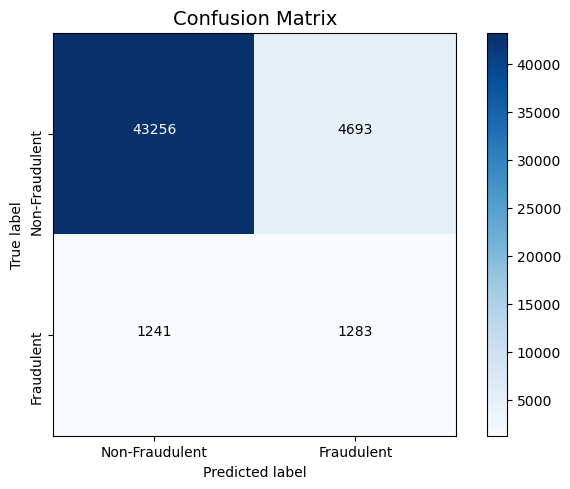

In [31]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

In [32]:
our_score(model, X_test, y_test)

0.526486535674763

ROC for test dataset 70.522%


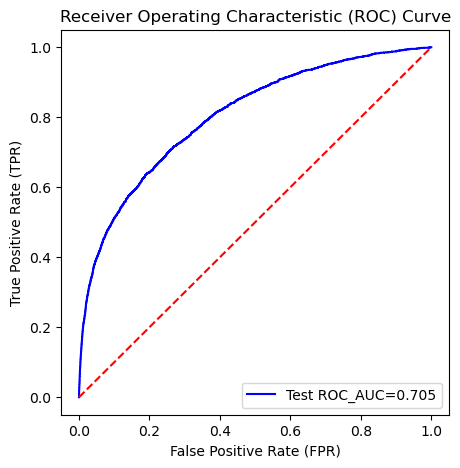

In [38]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred, average=None)
plot_roc_auc_curve(fpr, tpr, roc_auc)

In [40]:
print("Our score is equal to", our_score(model, X_test, y_test))

Our score is equal to 0.526486535674763


In [39]:
print("The initial loss was equal to", retrieved_money(model, X_test, y_test)[0], "dollars, \nwe retrieved", retrieved_money(model, X_test, y_test)[1], "dollars and the maximum amount that was retrievable is", retrieved_money(model, X_test, y_test)[2], "dollars.")

The initial loss was equal to -293332.17 dollars, 
we retrieved 137583.32 dollars and the maximum amount that was retrievable is 261323.53000000003 dollars.


In [42]:
print("Precision score is ", precision_score(y_test, y_pred))
print("Recall score is ", recall_score(y_test, y_pred))
print("f1 score is", f1_score(y_test, y_pred))

Precision score is  0.21469210174029452
Recall score is  0.5083201267828843
f1 score is 0.3018823529411765


## V. GridSearch

In [17]:
default_model = LogisticRegression()

In [61]:
weights_parameters = [{0:1, 1:w} for w in [5,10,15,20]]

In [41]:
gridsearch_parameters = {'solver' :['liblinear'], 'class_weight':weights_parameters}

In [42]:
grid_search = GridSearchCV(default_model, gridsearch_parameters, cv = 3, scoring = our_score)

In [43]:
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10},
                                          {0: 1, 1: 15}, {0: 1, 1: 20}],
                         'solver': ['liblinear']},
             scoring=<function our_score at 0x7f13687183a0>)

In [44]:
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score :", grid_search.best_score_)

Meilleurs paramètres : {'class_weight': {0: 1, 1: 15}, 'solver': 'liblinear'}
Meilleur score : 0.1844411577161145


Now we decide to fix the solver ('liblinear') and to find to best parameters for 'C' and 'class_weight'

In [18]:
weights_parameters_2 = [{0:1, 1:w} for w in [15,14,16]]

In [19]:
C_parameters = [1,10,100]

In [21]:
gridsearch_parameters_2 = {'solver' :['liblinear'], 'class_weight':weights_parameters_2, 'C':C_parameters }

In [22]:
grid_search_2 = GridSearchCV(default_model, gridsearch_parameters_2, cv = 3, scoring = our_score)

In [23]:
grid_search_2.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [1, 10, 100],
                         'class_weight': [{0: 1, 1: 15}, {0: 1, 1: 14},
                                          {0: 1, 1: 16}],
                         'solver': ['liblinear']},
             scoring=<function our_score at 0x7f6678fcf880>)

In [24]:
print("Meilleurs paramètres :", grid_search_2.best_params_)
print("Meilleur score :", grid_search_2.best_score_)

Meilleurs paramètres : {'C': 10, 'class_weight': {0: 1, 1: 16}, 'solver': 'liblinear'}
Meilleur score : 0.18486421521438198
